In [1]:
import os
os.getcwd()

'C:\\Users\\asmirnova5\\Desktop\\Python-scripts\\Python-notebook\\DIPLOMA'

In [2]:
import sys

import gc
import itertools
import math
import os
import random
import re
from datetime import datetime
from importlib import reload

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import pydotplus
import seaborn as sns
import shap

from IPython.display import Image
from lightgbm import LGBMClassifier
from scipy.stats import norm
from seaborn import heatmap
from sklearn import metrics, tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm


from pipeline_utils import (append_for_deletion, 
                            remove_from_deletion, 
                            funnel_func, 
                            mu,
                            roc_lift_gain, 
                            time_ranges_plot,
                            binary_hists, 
                            bootscores_concat,
                            by_month, 
                            check_nans, 
                            count_data, 
                            display_nicely,
                            drop_unnamed, 
                            get_pretty_dates, 
                            model_stats,
                            show_descriptions,
                            show_sources)

from ml_pipeline import (attributes_list_new, 
                         bootstrap,
                         br_correction, 
                         by_month_gini,
                         calculate_vif,
                         check_attribute_list_cases,
                         data_preprocessing,
                         data_preprocessing_test,
                         data_preprocessing_train,
                         feature_importance,
                         find_doubles_corr, 
                         find_meta_params,
                         find_meta_params_optuna,
                         find_ouliers_iqr, 
                         for_splines,
                         get_stats, 
                         get_stats_by_month,
                         get_stats_on_target,
                         get_stats_on_target_by_month, 
                         linear_calib_use_model_data,
                         lr_test_all_features, 
                         make_standard,
                         plot_meta_2d, 
                         receive_correlations,
                         simple_b_score_crm, 
                         stable_unstable,
                         stable_unstable_by_month_divide,
                         statistics_with_target,
                         stratified_split,
                         train_model_receive_stats,
                         turn_variables_with_values,
                         two_forests, 
                         union_datas)

ml_pipeline.py version: Created: 03.06.2022 01:09, Modified: 03.06.2022 01:08.


In [3]:
# путь основной папки
PATH = 'D:/Share/01 -Risk Desc Science/COLLECTION/Allocation_2019_new/segment_31_60/Data Sets'

model_alias='Allocation_31'    
segment_name='31'  
segment_number=1       
report_folder_path = 'G://Decision Science Sample/user_asmirnova5/coll' 


datasets_file = 'DS_ALLOCATION_31_60_RPC.csv'  
train_data = 'DS_ALLOCATION_31_60_train_RPC.csv'  
test_data = 'DS_ALLOCATION_31_60_test_RPC.csv' 
oot_data = 'DS_ALLOCATION_31_60_oot_RPC.csv' 

task = 'binary'

# description for variables
description_file = PATH +  '/Collection_Variables_v2.7.3.17.xlsx'

# categorical variables
categories_file = os.path.join(PATH, 'categories.xlsx')

# system variables
black_list_path = 'black_list.xlsx'

# meta params
missing_strings = 'MISSING'
p_value = 0.05

recommended_list = None 

# target description
target_dict = {'good': 0, 'bad': 1}

target = 'BF_CD'  # target name

hist_bad_rate_targets = [target]

index_month = 'DATE_REPORT'  #

# variables for stratification
list_of_vars_for_strat = [index_month]

sort_by_var = 'CIFID'  # client id

necessary_fields = list(set([target.upper(), index_month.upper(), sort_by_var.upper(), *[i.upper() for i in hist_bad_rate_targets]]))

list_of_vars_for_strat = [c.upper() for c in list_of_vars_for_strat]
for x in [target, index_month, sort_by_var]:
    x = x.upper()
    
dict_target = {v: k for k, v in target_dict.items()}

In [4]:
whitelist = []
whitelist = pd.Series(index=whitelist, data=[tuple('') for x in whitelist], dtype=str)
whitelist

Series([], dtype: object)

In [5]:
COL_SYS = ['SD',  'SD_INT','ID','GROUPID_C'
'CLIENT_NUMBER_C', 'CLIENT_NUMBER', 'SUPERID',  'UNNAMED: 0',
           'TEMP_SD', 'DATE_1_TEMP', 'DATE_3_TEMP','DATE_6_TEMP', 'DATE_12_TEMP','BUREAU_DT', 
           'APPLICATION_CVAL_C', 'REPORT_KEY','REPORT_KEY_C','CONTRACT_NUMBER','DAYSOVERDUE_SD',
          'MAX_DAYSOVERDUE_BF', 'BF', 'DAYSOVERDUE_SD_CD', 'MAX_DAYSOVERDUE_BF_CD']

COL_SYS = list(map(str.upper, COL_SYS))
COL_SYS = [x for x in COL_SYS if  x not in necessary_fields] 

In [400]:
train = pd.read_csv( PATH + '/'+ train_data,
                   delimiter='&',
                   index_col=0,
                  )

In [401]:
test = pd.read_csv( PATH + '/'+ test_data,
                   delimiter='&',
                   index_col=0,
                  )

In [402]:
oot = pd.read_csv( PATH + '/'+ oot_data,
                   delimiter='&',
                   index_col=0,
                  )

In [403]:
train.columns = list(map(str.upper, train.columns))
train = drop_unnamed(train) 
train.head()

CIFID          SD  C_BALANCETOTAL  C_BALANCEOVERDUE  C_SUMPAIDDEBT  \
2  1000003621  24.10.2018         5716.61            831.59     1023306.28   
3  1000004866  15.03.2019        39515.93           5700.86       19651.40   
4  1000006445  26.12.2018        27960.10           8373.78       10369.21   
6  1000006667  21.10.2018        10095.33           6742.96       44990.00   
8  1000008524  10.02.2019       312789.46          17782.61       26805.54   

   C_BALANCEPRINCIPLE  C_BALANCEOVERDUESHARE  C_MAXDAYSOVERDUEEVER  \
2             4908.42               0.145469                    43   
3            38546.60               0.144267                    31   
4            26871.79               0.299490                    31   
6             9925.00               0.667929                    31   
8           302174.46               0.056852                    31   

   C_MAXDPDCLIENT  C_COUNTACTIVECONTRACTS  ...  DATE_REPORT    SD_INT  \
2              31                       1  ...       201810  20181024   
3              31                       1  ...       201903  20190315   
4              31                       1  ...       201812  20181226   
6              31                       1  ...       201810  20181021   
8              31                       1  ...       201902  20190210   

   C_MAXDAYSTORPCALL12M  C_MINDAYSTORPCALL12M  DAYSOVERDUE_SD  \
2                   NaN                   NaN              31   
3                   1.0                   1.0              31   
4                  27.0                  10.0              31   
6                   NaN                   NaN              31   
8                   NaN                   NaN              31   

   MAX_DAYSOVERDUE_BF  BF  DAYSOVERDUE_SD_CD  MAX_DAYSOVERDUE_BF_CD  BF_CD  
2                   0   0                 31                      0      0  
3                   0   0                 31                      0      0  
4                  81   1                 31                     81      1  
6                  81   1                 31                     81      1  
8                  81   1                 31                     81      1  

[5 rows x 168 columns]

In [404]:
test.columns = list(map(str.upper, test.columns))
test = drop_unnamed(test) 
test.head()

CIFID          SD  C_BALANCETOTAL  C_BALANCEOVERDUE  C_SUMPAIDDEBT  \
0   1000003389  26.02.2019       560298.15          22242.19      245488.02   
1   1000003389  26.04.2019       536400.05          22526.79      268449.55   
5   1000006646  17.08.2018         4887.32           2405.71       17251.45   
7   1000008451  12.08.2018       307409.56          18374.65       30923.86   
18  1000017802  08.01.2019       378534.13          21834.17      238654.21   

    C_BALANCEPRINCIPLE  C_BALANCEOVERDUESHARE  C_MAXDAYSOVERDUEEVER  \
0            547751.98               0.097795                    31   
1            524790.45               0.107400                    36   
5              4759.55               0.492235                    31   
7            296226.74               0.271084                    31   
18           358514.69               0.124600                    33   

    C_MAXDPDCLIENT  C_COUNTACTIVECONTRACTS  ...  DATE_REPORT    SD_INT  \
0               31                       2  ...       201902  20190226   
1               31                       2  ...       201904  20190426   
5               31                       1  ...       201808  20180817   
7               31                       3  ...       201808  20180812   
18              31                       2  ...       201901  20190108   

    C_MAXDAYSTORPCALL12M  C_MINDAYSTORPCALL12M  DAYSOVERDUE_SD  \
0                   23.0                   0.0              31   
1                   30.0                   0.0              31   
5                   30.0                   9.0              31   
7                   29.0                   0.0              31   
18                 221.0                   0.0              31   

    MAX_DAYSOVERDUE_BF  BF  DAYSOVERDUE_SD_CD  MAX_DAYSOVERDUE_BF_CD  BF_CD  
0                   22   0                 31                     22      0  
1                   32   0                 31                     32      0  
5                   81   1                 31                     81      1  
7                   81   1                 31                     81      1  
18                  81   1                 31                     81      1  

[5 rows x 168 columns]

In [405]:
oot.columns = list(map(str.upper, oot.columns))
oot = drop_unnamed(oot) 
oot.head()

CIFID          SD  C_BALANCETOTAL  C_BALANCEOVERDUE  C_SUMPAIDDEBT  \
0   1000000504  27.05.2019       235815.20          20070.75       29468.55   
3   1000003389  14.06.2019       518445.68          21847.51      286997.88   
4   1000003516  20.05.2019       186404.95          26024.79      218501.85   
7   1000004992  18.05.2019       148733.83          11033.02      486969.48   
11  1000007062  07.06.2019       399047.60          29652.70       95635.42   

    C_BALANCEPRINCIPLE  C_BALANCEOVERDUESHARE  C_MAXDAYSOVERDUEEVER  \
0            226941.05               0.085112                    32   
3            506242.12               0.109459                    36   
4            177498.15               0.139614                    32   
7            134982.47               0.074180                    35   
11           377079.05               0.176584                    31   

    C_MAXDPDCLIENT  C_COUNTACTIVECONTRACTS  ...  DATE_REPORT    SD_INT  \
0               31                       1  ...       201905  20190527   
3               31                       2  ...       201906  20190614   
4               31                       1  ...       201905  20190520   
7               31                       1  ...       201905  20190518   
11              31                       2  ...       201906  20190607   

    C_MAXDAYSTORPCALL12M  C_MINDAYSTORPCALL12M  DAYSOVERDUE_SD  \
0                   35.0                   1.0              31   
3                   31.0                   0.0              31   
4                   30.0                   1.0              31   
7                    4.0                   4.0              31   
11                  75.0                   0.0              31   

    MAX_DAYSOVERDUE_BF  BF  DAYSOVERDUE_SD_CD  MAX_DAYSOVERDUE_BF_CD  BF_CD  
0                    0   0                 31                      0      0  
3                   81   1                 31                     81      1  
4                   81   1                 31                     81      1  
7                    0   0                 31                      0      0  
11                  81   1                 31                     81      1  

[5 rows x 168 columns]

In [406]:
changes_bin = pd.read_csv(os.path.join(PATH, 'Selection','changes_bin.csv'), sep = '&',  index_col=0,dtype="object")

In [407]:
var_dict = {x : changes.loc[changes['new variable'] == x, 'genuine variable'].iloc[0] for x in changes['new variable']}
sys_no_target = [x for x in necessary_fields if x != target]

In [408]:
deleted = pd.read_csv(os.path.join(PATH, 'Selection','deleted.csv'), sep=',', index_col=0)

In [409]:
deleted_ = deleted[(deleted == "('1% = 99%',)")
                  | (deleted == "('Blacklist',)")].dropna()

In [410]:
deleted_

deleted
SD                       ('Blacklist',)
MAX_DAYSOVERDUE_BF_CD    ('Blacklist',)
REGION_REG               ('Blacklist',)
MAX_DAYSOVERDUE_BF       ('Blacklist',)
DAYSOVERDUE_SD_CD        ('Blacklist',)
SD_INT                   ('Blacklist',)
BF                       ('Blacklist',)
DAYSOVERDUE_SD           ('Blacklist',)
REGION_HOME              ('Blacklist',)
C_MAXDPDCLIENT            ('1% = 99%',)
C_COUNTDELINQ00L1M        ('1% = 99%',)
C_COUNTOFPAYMENTS100L1M   ('1% = 99%',)

In [411]:
attribute_list_for_bin = attributes_list_new(train, train.columns)

Attribute_list:   0%|          | 0/168 [00:00<?, ?it/s]

In [412]:
attribute_list_for_bin.shape

(168, 21)

In [413]:
categories = pd.read_excel(categories_file)
categories['Переменная'] = [var.upper() for var in categories['Переменная']]
cats_from_file = categories['Переменная'].to_list()

In [414]:
survivors = [i for i in train.columns if i not in deleted_.index]
columns = [c for c in survivors if c not in necessary_fields]
len(columns)

153

In [415]:
binary = attribute_list_for_bin.loc[attribute_list_for_bin['count_dist'] == 2, 'attribute'].to_list()
objects = attribute_list_for_bin.loc[attribute_list_for_bin['type_val'] == 'object', 'attribute'].to_list()
all_cats = list(set(categories_from_list+ binary+objects))
categorical_columns = [i for i in columns if i in all_cats]
str_columns = [i for i in objects if i in columns]

In [416]:
categorical_columns

['C_COUNTDELINQ30L1M', 'PRSEDULEVEL', 'EMPINDUSTRY']

In [417]:
train[str_columns] = train[str_columns].fillna(missing_strings)

unique_vals = []
for i in str_columns:
    unique_vals.extend(list(train[i].unique()))
if len(unique_vals) > 500:
    print('Похоже, что категорий для LabelEncoder слишком много - проверьте лист many_distinct на присутствие ID (кроме необходимых) и были ли удалены признаки из Blacklist')

In [418]:
le = LabelEncoder()
le.fit(unique_vals)
for i in str_columns:
    train[i] = le.transform(train[i])
    # Сохраняем пропуски
    train[i].replace(to_replace = np.where(le.classes_ == missing_strings)[0][0], value = np.nan, inplace = True)

In [419]:
data, changes = make_standard(train,
                              columns,
                              target,
                              attribute_list_for_bin,
                              technical_list=COL_SYS,
                              categorial_list=categorical_columns,
                              label_encoder=le,
                              string_list=str_columns,
                              mis_value=missing_strings,
                              small_treshold=10)

all_columns_bin = tuple([i for i in data.columns if i not in COL_SYS])
print(len(all_columns_bin))

C_COUNTDELINQ30L1M
C_COUNTDELINQ30L1M | count_bin =  1 | del_bin =  0
PRSEDULEVEL
PRSEDULEVEL_0.0 4
PRSEDULEVEL_11.0 5
PRSEDULEVEL_12.0 1
PRSEDULEVEL_13.0 1
PRSEDULEVEL | count_bin =  14 | del_bin =  4
EMPINDUSTRY
EMPINDUSTRY | count_bin =  33 | del_bin =  0
227


In [425]:
changes

new variable      genuine variable  rule values
0       C_COUNTDELINQ30L1M_1    C_COUNTDELINQ30L1M    _1      1
2            PRSEDULEVEL_1.0           PRSEDULEVEL  _1.0      1
3            PRSEDULEVEL_2.0           PRSEDULEVEL  _2.0      2
4            PRSEDULEVEL_3.0           PRSEDULEVEL  _3.0      3
5            PRSEDULEVEL_4.0           PRSEDULEVEL  _4.0      4
..                       ...                   ...   ...    ...
68  C_SCHEDULE2FACTPAY3M_BIN  C_SCHEDULE2FACTPAY3M  _bin    NaN
69  C_SCHEDULE2FACTPAY1M_BIN  C_SCHEDULE2FACTPAY1M  _bin    NaN
70          EMPINCOMEAMT_BIN          EMPINCOMEAMT  _bin    NaN
71  C_MAXDAYSTORPCALL12M_BIN  C_MAXDAYSTORPCALL12M  _bin    NaN
72  C_MINDAYSTORPCALL12M_BIN  C_MINDAYSTORPCALL12M  _bin    NaN

[69 rows x 4 columns]

In [429]:
changes['genuine variable']

0       C_COUNTDELINQ30L1M
2              PRSEDULEVEL
3              PRSEDULEVEL
4              PRSEDULEVEL
5              PRSEDULEVEL
              ...         
68    C_SCHEDULE2FACTPAY3M
69    C_SCHEDULE2FACTPAY1M
70            EMPINCOMEAMT
71    C_MAXDAYSTORPCALL12M
72    C_MINDAYSTORPCALL12M
Name: genuine variable, Length: 69, dtype: object

In [438]:
cols = ['new variable', 'genuine variable', 'rule', 'values']

new_features_ch= []
for i in data.columns:
    if i in list(changes['new variable']):
        change = changes[changes['new variable'] == i]
        new_features_ch.append([list(change['new variable'])[0], list(change['genuine variable'])[0], 
                                  list(change['rule'])[0], list(change['values'])[0]])
    else:
        new_features_ch.append([i, i, 'Missing', np.nan])
    
changes_wo_corr = pd.DataFrame.from_records(new_features_ch, columns = cols)

In [437]:
changes_wo_corr.shape

(234, 4)

In [439]:
changes_wo_corr.to_csv(os.path.join(PATH, 'Selection','changes_wo_corr.csv'), sep = '&')
new_bins = changes_wo_corr['new variable'].to_list()
print(len(new_bins))

changes_wo_corr

234


new variable      genuine variable     rule values
0                       CIFID                 CIFID  Missing    NaN
1                          SD                    SD  Missing    NaN
2              C_BALANCETOTAL        C_BALANCETOTAL  Missing    NaN
3            C_BALANCEOVERDUE      C_BALANCEOVERDUE  Missing    NaN
4               C_SUMPAIDDEBT         C_SUMPAIDDEBT  Missing    NaN
..                        ...                   ...      ...    ...
229  C_SCHEDULE2FACTPAY3M_BIN  C_SCHEDULE2FACTPAY3M     _bin    NaN
230  C_SCHEDULE2FACTPAY1M_BIN  C_SCHEDULE2FACTPAY1M     _bin    NaN
231          EMPINCOMEAMT_BIN          EMPINCOMEAMT     _bin    NaN
232  C_MAXDAYSTORPCALL12M_BIN  C_MAXDAYSTORPCALL12M     _bin    NaN
233  C_MINDAYSTORPCALL12M_BIN  C_MINDAYSTORPCALL12M     _bin    NaN

[234 rows x 4 columns]

In [440]:
attribute_list_bin = attributes_list_new(data, list(all_columns_bin))

Attribute_list:   0%|          | 0/234 [00:00<?, ?it/s]

In [441]:
whitelist = []
whitelist = pd.Series(index=whitelist, data=[tuple('') for x in whitelist], dtype=str)
whitelist

Series([], dtype: object)

In [442]:
attribute_list_1_eq_99_2 = attribute_list_bin[(attribute_list_bin['1%'] == attribute_list_bin['99%'])]
deleted, whitelist = append_for_deletion(all_columns=all_columns,
                                         all_columns_bin=all_columns_bin,
                                         deleted=None,
                                         list_to_delete=attribute_list_1_eq_99_2.attribute.tolist(),
                                         reason='1% = 99% BIN',
                                         overwrite=False,
                                         necessary_fields=necessary_fields,
                                         whitelist=whitelist)

24 переменных записано на удаление, из них новых: 24.
После удаления в датасете останется 203 переменных (включая necessary_fields).


In [443]:
deleted

C_MAXDPDCLIENT             (1% = 99% BIN,)
C_COUNTDELINQ00L1M         (1% = 99% BIN,)
C_COUNTOFPAYMENTS100L1M    (1% = 99% BIN,)
PRSEDULEVEL_1.0            (1% = 99% BIN,)
PRSEDULEVEL_2.0            (1% = 99% BIN,)
PRSEDULEVEL_8.0            (1% = 99% BIN,)
PRSEDULEVEL_9.0            (1% = 99% BIN,)
PRSEDULEVEL_10.0           (1% = 99% BIN,)
PRSEDULEVEL_OTHER          (1% = 99% BIN,)
EMPINDUSTRY_0.0            (1% = 99% BIN,)
EMPINDUSTRY_4.0            (1% = 99% BIN,)
EMPINDUSTRY_5.0            (1% = 99% BIN,)
EMPINDUSTRY_7.0            (1% = 99% BIN,)
EMPINDUSTRY_8.0            (1% = 99% BIN,)
EMPINDUSTRY_9.0            (1% = 99% BIN,)
EMPINDUSTRY_11.0           (1% = 99% BIN,)
EMPINDUSTRY_16.0           (1% = 99% BIN,)
EMPINDUSTRY_17.0           (1% = 99% BIN,)
EMPINDUSTRY_18.0           (1% = 99% BIN,)
EMPINDUSTRY_19.0           (1% = 99% BIN,)
EMPINDUSTRY_23.0           (1% = 99% BIN,)
EMPINDUSTRY_28.0           (1% = 99% BIN,)
EMPINDUSTRY_30.0           (1% = 99% BIN,)
EMPINDUSTRY

In [444]:
attribute_list_one_value_2 = attribute_list_bin[attribute_list_bin['count_dist'] == 1]

# Добавляем one_value_binned на удаление
deleted, whitelist = append_for_deletion(all_columns=all_columns,
                                         all_columns_bin=all_columns_bin,
                                         deleted=deleted,
                                         list_to_delete=attribute_list_one_value_2.attribute.tolist(),
                                         reason='one_value_BIN',
                                         overwrite=False,
                                         necessary_fields=necessary_fields,
                                         whitelist=whitelist)

1 переменных записано на удаление, из них новых: 0.
После удаления в датасете останется 203 переменных (включая necessary_fields).


In [445]:
deleted

C_MAXDPDCLIENT             (1% = 99% BIN, one_value_BIN)
C_COUNTDELINQ00L1M                       (1% = 99% BIN,)
C_COUNTOFPAYMENTS100L1M                  (1% = 99% BIN,)
PRSEDULEVEL_1.0                          (1% = 99% BIN,)
PRSEDULEVEL_2.0                          (1% = 99% BIN,)
PRSEDULEVEL_8.0                          (1% = 99% BIN,)
PRSEDULEVEL_9.0                          (1% = 99% BIN,)
PRSEDULEVEL_10.0                         (1% = 99% BIN,)
PRSEDULEVEL_OTHER                        (1% = 99% BIN,)
EMPINDUSTRY_0.0                          (1% = 99% BIN,)
EMPINDUSTRY_4.0                          (1% = 99% BIN,)
EMPINDUSTRY_5.0                          (1% = 99% BIN,)
EMPINDUSTRY_7.0                          (1% = 99% BIN,)
EMPINDUSTRY_8.0                          (1% = 99% BIN,)
EMPINDUSTRY_9.0                          (1% = 99% BIN,)
EMPINDUSTRY_11.0                         (1% = 99% BIN,)
EMPINDUSTRY_16.0                         (1% = 99% BIN,)
EMPINDUSTRY_17.0               

In [446]:
train = turn_variables_with_values(train, changes_wo_corr)
test = turn_variables_with_values(test, changes_wo_corr)
oot = turn_variables_with_values(oot, changes_wo_corr)

In [447]:
train.head()

CIFID          SD  C_BALANCETOTAL  C_BALANCEOVERDUE  C_SUMPAIDDEBT  \
2  1000003621  24.10.2018         5716.61            831.59     1023306.28   
3  1000004866  15.03.2019        39515.93           5700.86       19651.40   
4  1000006445  26.12.2018        27960.10           8373.78       10369.21   
6  1000006667  21.10.2018        10095.33           6742.96       44990.00   
8  1000008524  10.02.2019       312789.46          17782.61       26805.54   

   C_BALANCEPRINCIPLE  C_BALANCEOVERDUESHARE  C_MAXDAYSOVERDUEEVER  \
2             4908.42               0.145469                    43   
3            38546.60               0.144267                    31   
4            26871.79               0.299490                    31   
6             9925.00               0.667929                    31   
8           302174.46               0.056852                    31   

   C_MAXDPDCLIENT  C_COUNTACTIVECONTRACTS  ...  C_PTPNB2PTPALLL6M_BIN  \
2              31                       1  ...                      0   
3              31                       1  ...                      0   
4              31                       1  ...                      0   
6              31                       1  ...                      0   
8              31                       1  ...                      0   

   C_PTPNB2PTPALLL3M_BIN  C_PTPNB2PTPALLL1M_BIN  C_SCHEDULE2FACTPAY12M_BIN  \
2                      0                      0                          0   
3                      0                      0                          1   
4                      0                      0                          1   
6                      0                      0                          1   
8                      0                      0                          1   

   C_SCHEDULE2FACTPAY6M_BIN  C_SCHEDULE2FACTPAY3M_BIN  \
2                         0                         0   
3                         1                         1   
4                         1                         1   
6                         1                         1   
8                         1                         1   

   C_SCHEDULE2FACTPAY1M_BIN  EMPINCOMEAMT_BIN  C_MAXDAYSTORPCALL12M_BIN  \
2                         0                 1                         0   
3                         1                 1                         1   
4                         1                 1                         1   
6                         1                 1                         0   
8                         1                 1                         0   

   C_MINDAYSTORPCALL12M_BIN  
2                         0  
3                         1  
4                         1  
6                         0  
8                         0  

[5 rows x 234 columns]

In [448]:
y_train = train[target]
y_test = test[target]
y_oot = oot[target]

train.drop(target, axis = 1, inplace = True)
test.drop(target, axis = 1, inplace = True)
oot.drop(target, axis = 1, inplace = True)

display(train.head())

CIFID          SD  C_BALANCETOTAL  C_BALANCEOVERDUE  C_SUMPAIDDEBT  \
2  1000003621  24.10.2018         5716.61            831.59     1023306.28   
3  1000004866  15.03.2019        39515.93           5700.86       19651.40   
4  1000006445  26.12.2018        27960.10           8373.78       10369.21   
6  1000006667  21.10.2018        10095.33           6742.96       44990.00   
8  1000008524  10.02.2019       312789.46          17782.61       26805.54   

   C_BALANCEPRINCIPLE  C_BALANCEOVERDUESHARE  C_MAXDAYSOVERDUEEVER  \
2             4908.42               0.145469                    43   
3            38546.60               0.144267                    31   
4            26871.79               0.299490                    31   
6             9925.00               0.667929                    31   
8           302174.46               0.056852                    31   

   C_MAXDPDCLIENT  C_COUNTACTIVECONTRACTS  ...  C_PTPNB2PTPALLL6M_BIN  \
2              31                       1  ...                      0   
3              31                       1  ...                      0   
4              31                       1  ...                      0   
6              31                       1  ...                      0   
8              31                       1  ...                      0   

   C_PTPNB2PTPALLL3M_BIN  C_PTPNB2PTPALLL1M_BIN  C_SCHEDULE2FACTPAY12M_BIN  \
2                      0                      0                          0   
3                      0                      0                          1   
4                      0                      0                          1   
6                      0                      0                          1   
8                      0                      0                          1   

   C_SCHEDULE2FACTPAY6M_BIN  C_SCHEDULE2FACTPAY3M_BIN  \
2                         0                         0   
3                         1                         1   
4                         1                         1   
6                         1                         1   
8                         1                         1   

   C_SCHEDULE2FACTPAY1M_BIN  EMPINCOMEAMT_BIN  C_MAXDAYSTORPCALL12M_BIN  \
2                         0                 1                         0   
3                         1                 1                         1   
4                         1                 1                         1   
6                         1                 1                         0   
8                         1                 1                         0   

   C_MINDAYSTORPCALL12M_BIN  
2                         0  
3                         1  
4                         1  
6                         0  
8                         0  

[5 rows x 233 columns]

In [455]:
delete_for_forest = list(set(list(deleted.index) + list(deleted_.index) + list(COL_SYS)))

In [457]:
columns_no_sys = [x for x in changes_wo_corr['new variable'].to_list() if x not in necessary_fields
                 and x not in delete_for_forest]

attribute_list = attributes_list_new(train[columns_no_sys], 
                                           columns_no_sys, 
                                           [0.01, 0.5, 1, 2, 5, 95, 97, 98, 99, 99.5, 99.99])

Attribute_list:   0%|          | 0/198 [00:00<?, ?it/s]

In [458]:
attribute_list['right_border'] = attribute_list['99%']
attribute_list['left_border'] = attribute_list['1%']

In [459]:
list_of_categories_sel = attribute_list.loc[(attribute_list['count_dist'] == 2), 'attribute'].to_list() 
categories_data_fin = pd.read_csv(os.path.join(PATH, 'Selection','categories_fin.csv'), sep = '&', index_col=0)

for i in columns_no_sys:
    if (i in categories_data_fin['feature'].to_list()) & (i not in list_of_categories_sel):
        list_of_categories_sel.append(i)

In [462]:
len(columns_no_sys)

198

In [463]:
columns_bin = columns_no_sys
features_bin = [x for x in columns_bin if x not in necessary_fields]

categories_bin = [x for x in list_of_categories_sel if x in features_bin]
sys_no_target = [x for x in necessary_fields if x != target]

In [464]:
dicts = {'high_outlier': 99, 'low_outlier': 1}

In [465]:
non_outliers = attribute_list.loc[attribute_list[str(dicts['high_outlier'])+'%'] == attribute_list['1%'], 'attribute'].to_list()
cols_outliers = [x for x in features_bin if x not in non_outliers]

In [466]:
train_bin, test_bin, y_train, y_test, scaler_bin = data_preprocessing(train[[*features_bin, *sys_no_target]],
                                                                                y_train,
                                                                                test[[*features_bin,
                                                                                      *sys_no_target]],
                                                                                y_test,
                                                                                necessary_fields,
                                                                                categorial_list=categories_bin,
                                                                                yeo_johnson=False,
                                                                                attribute_list=attribute_list,
                                                                                var_col='attribute',
                                                                                scale='mean',
                                                                                median='val_mediana',
                                                                                check_percentile=5,
                                                                                high_outlier='right_border',
                                                                                low_outlier='left_border',
                                                                                cols_outlier=cols_outliers,
                                                                                cut_non_out_9999=True)


oot_bin = data_preprocessing_test(oot[[*features_bin, *sys_no_target]], 
                              y_oot, 
                              necessary_fields, 
                              categorial_list=categories_bin,
                              drop_technical=True,
                              attribute_list=attribute_list, 
                              var_col='attribute',
                              median='val_mediana',
                              high_outlier='right_border', 
                              low_outlier='left_border', 
                              scale=scaler_bin,
                              yeo_johnson=None, 
                              cols_outlier=cols_outliers)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

# Two Forest (Wrapper)

In [467]:
necessary_fields

['CIFID', 'BF_CD', 'DATE_REPORT']

In [468]:
data = pd.concat([train_bin, y_train, train[['CIFID', 'DATE_REPORT']]], axis=1)

In [469]:
vc = y_train.value_counts()
w_b = vc.loc[1]/vc.loc[0]

w1 = [  
    {0: round(0.75*w_b, 4), 1: 1},
    {0: round(w_b, 4), 1: 1},
    {0: round(1.5*w_b, 4), 1: 1},
    {0: round(2.5*w_b, 4), 1: 1},
    {0: round(3*w_b, 4), 1: 1},
    {0: round(4*w_b, 4), 1: 1},
    {0: round(5*w_b, 4), 1: 1},
    {0: round(6*w_b, 4), 1: 1}
]


number_of_trees = [1*train_bin.shape[1],
                   round(1.10*train_bin.shape[1]),
                   round(1.25*train_bin.shape[1])]

print('1:', '{:.2%}'.format(vc.loc[1]/vc.sum()), '\n0:', '{:.2%}'.format(vc.loc[0]/vc.sum()), '\nw_b(0):', round(w_b,4))
print('w1:', w1)
print('number_of_trees:', number_of_trees)

1: 36.80% 
0: 63.20% 
w_b(0): 0.5824
w1: [{0: 0.4368, 1: 1}, {0: 0.5824, 1: 1}, {0: 0.8736, 1: 1}, {0: 1.456, 1: 1}, {0: 1.7472, 1: 1}, {0: 2.3296, 1: 1}, {0: 2.912, 1: 1}, {0: 3.4944, 1: 1}]
number_of_trees: [198, 218, 248]


In [470]:
X_1, X_2, y_1, y_2 = stratified_split(data, target, list_of_vars_for_strat, sort_by_var, 
                                      size_of_test = 0.5, drop_technical = True, random_state = 241)
X_1.shape, X_1.dropna().shape

((86278, 198), (86278, 198))

In [471]:
random_params = {'max_depth': 3,
                 'class_weight': 'balanced',
                 'n_estimators': data.shape[1],
                 'max_features': 0.15,
                 'min_samples_leaf': 5,
                 'min_samples_split': 10,
                 'random_state': 241}

In [472]:
def forest_stats(rf, X_train, y_train, X_test, y_test):
    
    forest_st = pd.DataFrame(columns = ['Train', 'Test'], index=['APS', 'ROC AUC', 'Gini'])
    
    y_pred_train = rf.predict_proba(X_train)[:,1]
    y_pred_test = rf.predict_proba(X_test)[:,1]

    forest_st.loc['APS','Train'] = average_precision_score(y_train, y_pred_train)
    forest_st.loc['APS','Test'] = average_precision_score(y_test, y_pred_test)
    forest_st.loc['ROC AUC','Train'] = roc_auc_score(y_train, y_pred_train)
    forest_st.loc['ROC AUC','Test'] = roc_auc_score(y_test, y_pred_test)
    forest_st.loc['Gini','Train'] = 2*forest_st.loc['ROC AUC','Train']-1
    forest_st.loc['Gini','Test'] = 2*forest_st.loc['ROC AUC','Test']-1
    display(forest_st.style.format("{:.2%}"))
    return forest_st

In [473]:
# train two forests
rf = RandomForestClassifier(**random_params)
rf.fit(X_1, y_1)
print('Forest 1')
f1 = forest_stats(rf, X_train=X_1, y_train=y_1, X_test=X_2, y_test=y_2)

rf = RandomForestClassifier(**random_params)
rf.fit(X_2, y_2)
print('Forest 2')
f2 = forest_stats(rf, X_train=X_2, y_train=y_2, X_test=X_1, y_test=y_1)

Forest 1


Forest 2


In [474]:
grid_params = {'max_depth': [2, 3, 4], 
               'class_weight': w1, 
               'n_estimators': number_of_trees, 
               'max_features': [0.15],
               'min_samples_leaf': [5], 
               'min_samples_split': [10], 
               'random_state': [241]}
grid_params

{'max_depth': [2, 3, 4],
 'class_weight': [{0: 0.4368, 1: 1},
  {0: 0.5824, 1: 1},
  {0: 0.8736, 1: 1},
  {0: 1.456, 1: 1},
  {0: 1.7472, 1: 1},
  {0: 2.3296, 1: 1},
  {0: 2.912, 1: 1},
  {0: 3.4944, 1: 1}],
 'n_estimators': [198, 218, 248],
 'max_features': [0.15],
 'min_samples_leaf': [5],
 'min_samples_split': [10],
 'random_state': [241]}

In [475]:
scorings = ['average_precision', 'roc_auc']

grid = GridSearchCV(RandomForestClassifier(),
                    grid_params,
                    scoring=scorings,
                    verbose=1,
                    cv=3,
                    n_jobs=3,
                    refit='roc_auc')

grid.fit(data.drop(necessary_fields, axis=1), data[target])

print('Best_estimator:', grid.best_estimator_ , '\nBest_score:', grid.best_score_, '\nBest_params:', grid.best_params_)
print('Mean_test_roc_auc:\n', grid.cv_results_['mean_test_roc_auc'])

best_params_data_forest = pd.DataFrame.from_dict(grid.best_params_)
results_of_grid_search = pd.DataFrame.from_dict(grid.cv_results_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 17.6min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 81.1min
[Parallel(n_jobs=3)]: Done 216 out of 216 | elapsed: 91.9min finished


Best_estimator: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.7472, 1: 1}, criterion='gini',
                       max_depth=4, max_features=0.15, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=248, n_jobs=None, oob_score=False,
                       random_state=241, verbose=0, warm_start=False) 
Best_score: 0.7988044247890563 
Best_params: {'class_weight': {0: 1.7472, 1: 1}, 'max_depth': 4, 'max_features': 0.15, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 248, 'random_state': 241}
Mean_test_roc_auc:
 [0.77664936 0.77702493 0.77726595 0.78635458 0.78630401 0.78658119
 0.79695273 0.79699893 0.79701331 0.77710175 0.77739082 0.77779952
 0.78678818 0.78662041 0.78694761 0.79732357 0.79742492 0.7975362

In [476]:
best_params_data_forest.to_excel(os.path.join(PATH, 'Selection','RandomForest_params_wo_cor.xlsx'), index = False)
results_of_grid_search.to_excel(os.path.join(PATH, 'Selection','RandomForest_results_wo_co.xlsx'), index = False)

In [477]:
rf = RandomForestClassifier(**grid.best_params_)
rf.fit(X_1, y_1)
print('Forest 1')
f1 = forest_stats(rf, X_train=X_1, y_train=y_1, X_test=X_2, y_test=y_2)

rf = RandomForestClassifier(**grid.best_params_)
rf.fit(X_2, y_2)
print('Forest 2')
f2 = forest_stats(rf, X_train=X_2, y_train=y_2, X_test=X_1, y_test=y_1)

Forest 1


Forest 2


In [478]:
params_dict = {**random_params}
params_dict

{'max_depth': 3,
 'class_weight': 'balanced',
 'n_estimators': 201,
 'max_features': 0.15,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'random_state': 241}

In [479]:
importance_test, import1_test, import2_test = two_forests(data1=X_1,
                                                          y1=y_1,
                                                          data2=X_2,
                                                          y2=y_2,
                                                          param_dict=params_dict,
                                                          task=task,
                                                          higher_is_better=True,
                                                          use_metric=average_precision_score,
                                                          treshold_metric=False,
                                                          features_list=None,
                                                          n_samples_our=-1,
                                                          several_perms=None,
                                                          random_state=241)

Start of random forest fit | time:  09.06.2022 19:44:10
First random forest end | time:  09.06.2022 19:44:59 Score train: 0.664 Score test: 0.6713
Second random forest end | time:  09.06.2022 19:45:50 Score train: 0.6737 Score test: 0.662

FIRST IMPORTANCE:


Two Forests:   0%|          | 0/198 [00:00<?, ?it/s]

SECOND IMPORTANCE:


Two Forests:   0%|          | 0/198 [00:00<?, ?it/s]

In [480]:
thresh_p = 0.1

mean_APS = (f1.loc['APS', 'Test']+f2.loc['APS', 'Test'])/2

importance_test['av_precision'] = mean_APS
importance_test['percent'] = importance_test['Importance']/importance_test['av_precision']
importance_test.sort_values(by = 'Importance', ascending = False, inplace = True)

imp_test = importance_test[(importance_test['p_value'] < thresh_p)]['Feature'].to_list()
not_imp_2forests = importance_test[(importance_test['p_value'] >= thresh_p)]['Feature'].to_list()

print('All vars', len(importance_test))
print('Important var:', len(imp_test))
print('Unimportant var:', len(not_imp_2forests))
print('\nImportant var:\n\n', imp_test)

All vars 198
Important var: 72
Unimportant var: 126

Important var:

 ['C_COUNTDAYSCALLL1M', 'C_COUNTDAYSCALLL7D', 'C_DAYSINDELINQUENCYL12M', 'C_SUMOFPAYMENTSL1M2TD', 'C_PERCENTDAYSINDELINQUENCYL12M', 'C_DAYSSINCELASTPAYMENT12M', 'C_COUNTDAYSTASKL7D_NEWLOG', 'C_COUNTDAYSTASKL1M_NEWLOG', 'C_BALANCEOVERDUE', 'C_SUMOFPAYMENTSL3M2TD', 'C_SUMOFPAYMENTSL1M2L3M', 'C_PERCENTDAYSINDELINQUENCYL6M', 'C_DAYSINDELINQUENCYL6M', 'C_SUMOFPAYMENTSL1M', 'C_SCHEDULE2FACTPAY1M', 'C_COUNTDAYSTASKL3M_NEWLOG', 'C_BALANCEOVERDUESHARE', 'C_COUNTPTP2COUNTPAYALLL1M_BIN', 'C_COUNTDAYSCALLL3M', 'C_COUNTOFPAYMENTSL1M', 'C_BALANCETOTAL', 'C_DAYSINDELINQUENCYL3M', 'C_CURPTPAMTALLL12M2BT', 'C_COUNTDELINQ00L12M', 'C_COUNTDELINQ00L6M', 'C_COUNTOPERATORCALLL1M', 'C_AVGDAYSL3MTOL12M_NEWLOG', 'C_COUNTSYSTEMONLYCALLL7D', 'C_MAXDAYSOVERDUEEVER', 'C_PERCENTDAYSINDELINQUENCYL3M', 'C_COUNTOFTPCL1M', 'C_COUNTOFCC', 'C_BALANCEPRINCIPLE', 'C_COUNTACTIVECONTRACTS', 'C_AVGDAYSL3MTOL6M_NEWLOG', 'C_CURPTPAMTALLL12M2BO', 'C_MAXPAYMENTL

In [481]:
categorical_data = pd.read_csv(os.path.join(PATH, 'Selection','categorical_data.csv'), sep='&', index_col=0)
changes = pd.read_csv(os.path.join(PATH, 'Selection','changes.csv'), sep = '&', index_col=0)
categorical_columns = categorical_data['variable'].to_list()

definition_4 = statistics_with_target(data, imp_test, target, category_list = categorical_columns)
definition_4.to_excel(os.path.join(PATH, 'Selection','definition_two_forests_wo_corr.xlsx'),  index = False)

Statistics_with_target:   0%|          | 0/72 [00:00<?, ?it/s]

In [482]:
definition_4

variable    stat pvalue      corr corr name
0               C_COUNTDAYSCALLL1M   0.000000e+00  0.337047      corr
1               C_COUNTDAYSCALLL7D   0.000000e+00  0.359421      corr
2          C_DAYSINDELINQUENCYL12M   0.000000e+00 -0.098972      corr
3            C_SUMOFPAYMENTSL1M2TD   0.000000e+00 -0.155142      corr
4   C_PERCENTDAYSINDELINQUENCYL12M   0.000000e+00 -0.098972      corr
..                             ...            ...       ...       ...
67          C_COUNTOFBROKENPTPL12M   6.365848e-04 -0.029553      corr
68           C_COUNTOFBROKENPTPL3M   1.935562e-08 -0.010061      corr
69             C_SUMOFPAYMENTSL12M  2.114838e-293  0.129176      corr
70         C_CURPTPAMTALLL1M2LP12M  3.059027e-112 -0.005033      corr
71                     CCDLOANRATE  3.228569e-222  0.072745      corr

[72 rows x 4 columns]

In [483]:
features_forest = imp_test

In [484]:
pass_model_logreg = LogisticRegression

C = [0.05, 0.1, 0.2, 0.3, 0.5, 1, 1.5]
CC  = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 1.5]
w = np.multiply(CC, w_b)

high_outs = [99]
low_outs = [1]
params_preproc_grid = {'high_outlier': high_outs, 'low_outlier': low_outs}
combination_preproc = list(itertools.product(*params_preproc_grid.values()))

params_dictionary = {'C': C,
                     'weight_0': w,
                     'regularization': 'l2', 
                     'random_state': 241,
                     'solver': 'liblinear', 
                     'max_iter':  [300]}

params_to_model = {'C': 'C', 
                   'weight_0': 'class_weight', 
                   'regularization': 'penalty', 
                   'random_state': 'random_state',
                   'solver': 'solver', 
                   'max_iter': 'max_iter'}

In [485]:
new_meta_with_prepr2 = []

for combination in combination_preproc:
    outputs = list(combination)
    dicts = {}
    for position in range(len(combination)):
        dicts[list(params_preproc_grid.keys())[position]] = combination[position]

    non_outliers = attribute_list.loc[attribute_list[str(dicts['high_outlier'])+'%'] == attribute_list['1%'], 'attribute'].to_list()
    
    cols_outliers = [x for x in attribute_list if x not in non_outliers]

    print('-'*20, dicts, non_outliers, '-'*20)
    i_meta2 = find_meta_params(train[[*features_forest, *sys_no_target]],
                               y_train,
                               params_dictionary,
                               params_to_model,
                               pass_model_logreg,
                               sort_by_var= sort_by_var.upper(),
                               list_of_vars_for_strat =[index_month],
                               n_folds=5,
                               second_target=None,
                               yeo_johnson=False,
                               attribute_list=None,
                               var_col=None,
                               categorial_list=categories_bin,
                               cols_outlier=cols_outliers,
                               need_business=False,
                               draw=True,
                               draw_by_approval_rate=False,
                               simple_b_score=None,
                               business_dict= None,
                               business_dict_sec=None,
                               scale='mean',
                               median='median',
                               high_outlier=dicts['high_outlier'],
                               low_outlier=dicts['low_outlier'],
                               check_percentile=1,
                               random_state=241,
                               task='binary',
                               k_logs=10,
                               cut_non_out_9999=True)
    i_meta2['high_outlier'] = dicts['high_outlier']
    i_meta2['low_outlier'] = dicts['low_outlier']
    new_meta_with_prepr2.append(i_meta2)

i_meta2['weight'] = round(i_meta2['weight_0'], 5)

-------------------- {'high_outlier': 99, 'low_outlier': 1} [] --------------------
{'C': [0.05, 0.1, 0.2, 0.3, 0.5, 1, 1.5], 'weight_0': array([0.00291197, 0.00582395, 0.02911974, 0.05823948, 0.11647895,
       0.29119738, 0.58239477, 0.87359215]), 'regularization': ['l2'], 'random_state': [241], 'solver': ['liblinear'], 'max_iter': [300]}
-------------------- 09.06.2022 19:55:48 0 -------------------- 
 Параметры: {'C': 0.05, 'class_weight': {0: 0.002911973836514965, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.6417487077702125 
 Среднее значение AUC = 0.7896400301331635
-------------------- 09.06.2022 19:57:07 1 -------------------- 
 Параметры: {'C': 0.05, 'class_weight': {0: 0.00582394767302993, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.649085374185487 
 Среднее значение AUC = 0.7935619718967646
-------------------- 09.06.2022 20:13:42 10 -------

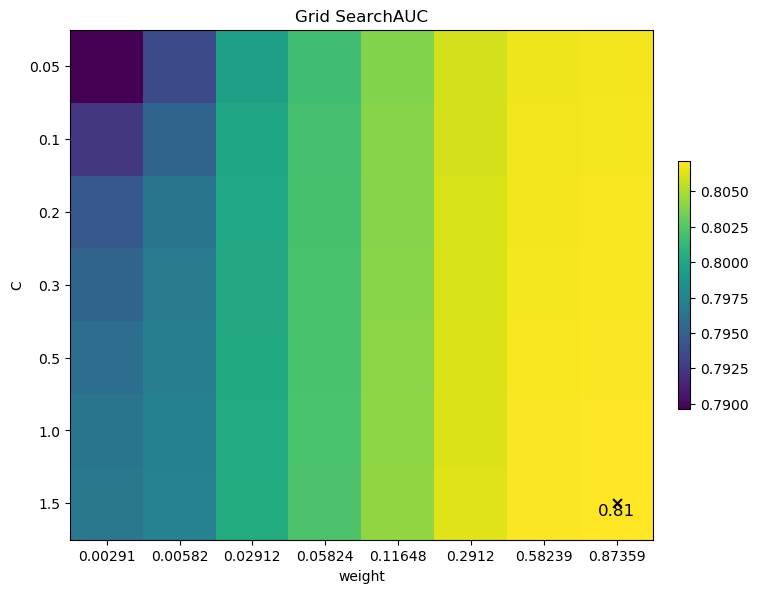

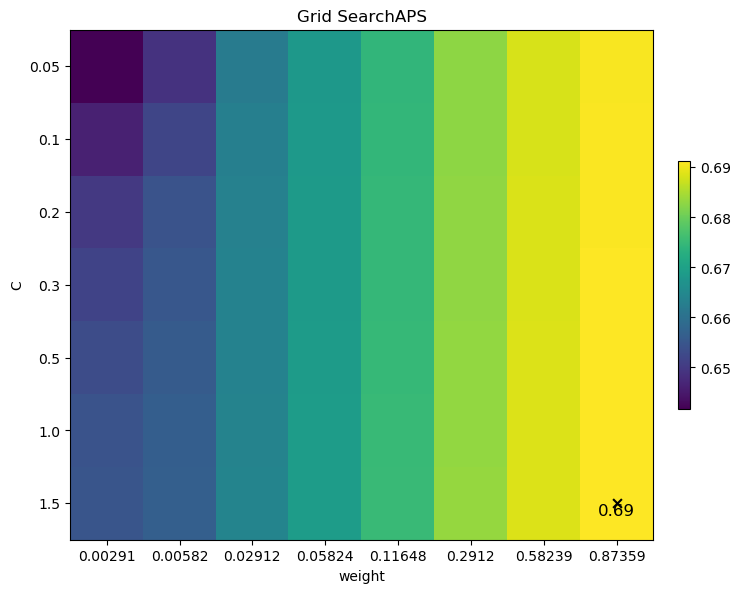

In [486]:
plot_meta_2d(meta=i_meta2, first_dimention='C', second_dimention='weight', b_best='AUC')
plot_meta_2d(meta=i_meta2, first_dimention='C', second_dimention='weight', b_best='APS')
i_meta2.to_csv(os.path.join(PATH, 'Modeling','Logreg','i_meta2.csv'), sep='&')

In [487]:
attribute_list.to_csv(os.path.join(PATH, 'Modeling', 'Logreg', 'attribute_list_logreg.csv'), sep='&')

In [488]:
params_dict = {'weight_0': 'class_weight', 'C': 'C', 'max_iter': 'max_iter'}
other_hyps = {'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
pass_model_logreg = LogisticRegression

print(50*'-', 'By AUC', 50*'-')
model_logreg, auc_scores, y_test_pred_logreg = train_model_receive_stats(train_bin[features_forest],
                                                                         y_train,
                                                                         test_bin[features_forest],
                                                                         y_test,
                                                                         meta=i_meta2,
                                                                         by_var='AUC',
                                                                         params_dict=params_dict,
                                                                         other_hyperparams=other_hyps,
                                                                         pass_model=pass_model_logreg,
                                                                         need_business=False,
                                                                         simple_b_score=None,
                                                                         business_dict=None,
                                                                         printed=True,
                                                                         task='binary')


y_train_pred_logreg = model_logreg.predict_proba(train_bin[features_forest])[:, 1]
y_oot_pred_logreg = model_logreg.predict_proba(oot_bin[features_forest])[:, 1]

joblib.dump(model_logreg, os.path.join(PATH, 'Modeling','Logreg','model_logreg_forest.dat'))
joblib.dump(scaler_bin, os.path.join(PATH, 'Modeling','Logreg','scaler_logreg_forest.dat'))

-------------------------------------------------- By AUC --------------------------------------------------
{'class_weight': {0: 0.8735921509544895, 1: 1}, 'C': 1.5, 'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
09.06.2022 22:19:39 start of logit fit
09.06.2022 22:20:48 end of logit fit
09.06.2022 22:20:48
-------------------- Statistics --------------------
Brier score =  0.17197224420124677
--------------------
AUC =  0.8060870219179006
AUC train = 0.8106787610898607
Gini =  0.6121740438358012
Gini train = 0.6213575221797214
Stability = 0.9852202990772453
Average precision score =  0.6886477904348318
---------- Treshold by F_score ----------
Accuracy =  0.6973681154033775
Score F1 =  0.6679072138669386
Precision =  0.5604226376352826
Recall =  0.826405096827099
Approval rate =  0.5430323584752259


['D:/Share/01 -Risk Desc Science/COLLECTION/Allocation_2019_new/segment_31_60/Data Sets\\Modeling\\Logreg\\scaler_logreg_forest.dat']

In [489]:
logreg_stats = model_stats(clf=model_logreg, data_dict={'Train': [train_bin[features_forest], y_train],
                                                        'Test': [test_bin[features_forest], y_test], 
                                                        'OOT': [oot_bin[features_forest], y_oot]},
                           round_to = 5)

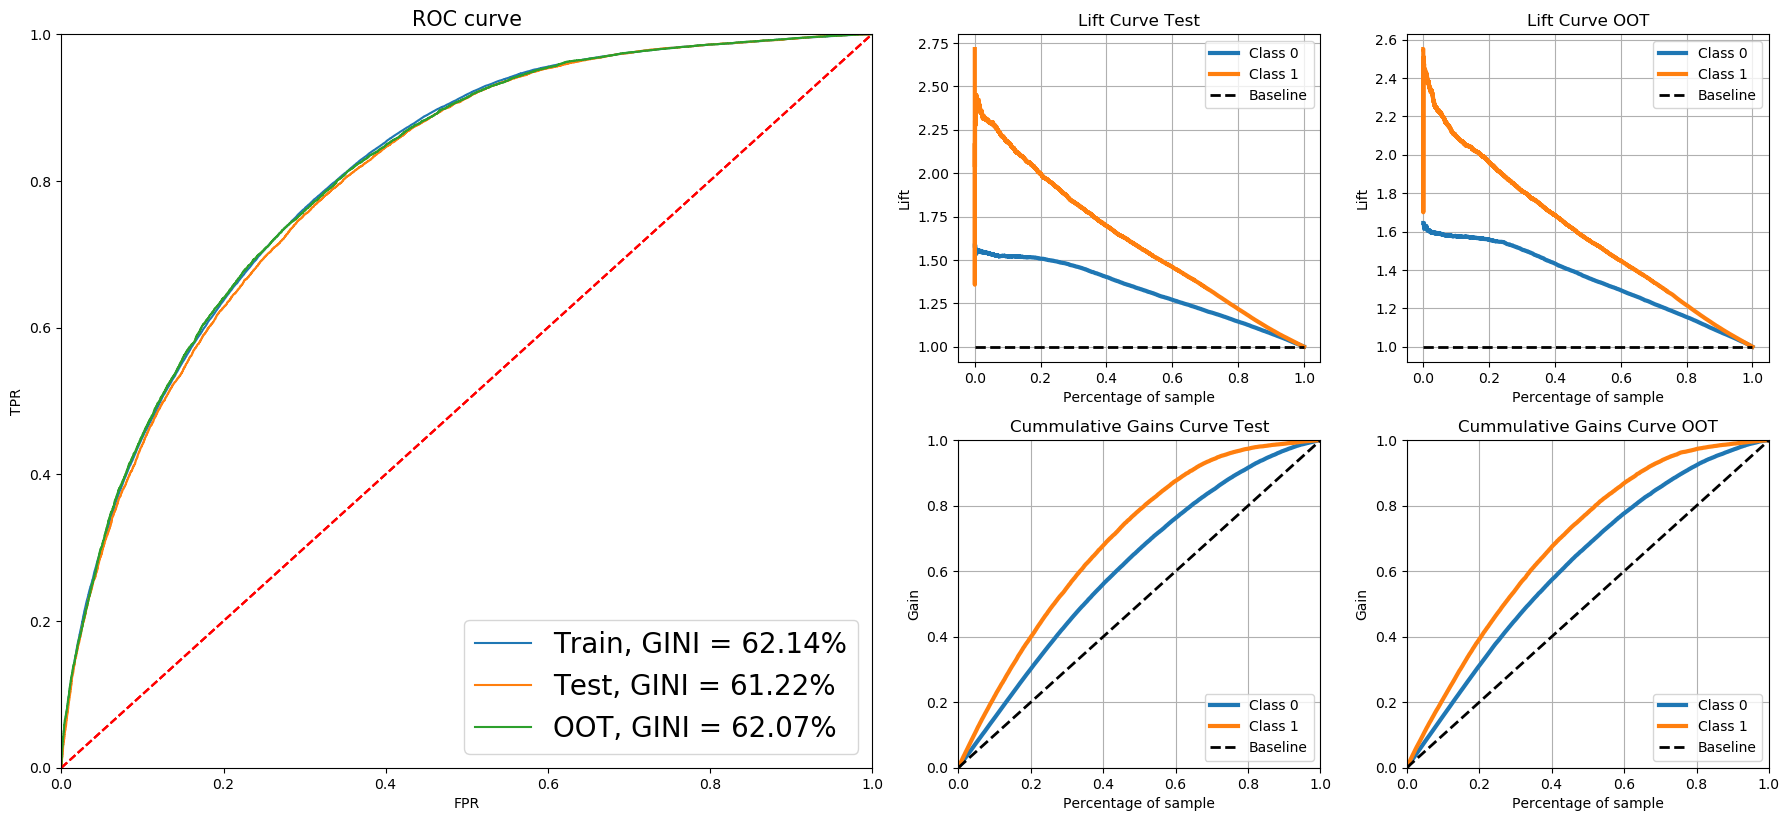

In [490]:
roc_lift_gain(model=model_logreg, 
              data = {'Train':[train_bin[features_forest], y_train], 
                      'Test':[test_bin[features_forest], y_test], 
                      'OOT':[oot_bin[features_forest], y_oot]})

In [491]:
train_lgbm, test_lgbm, y_train, y_test = data_preprocessing(train[features_forest],
                                                                      y_train,
                                                                      test[features_forest],
                                                                      y_test,
                                                                      necessary_fields,
                                                                      categorial_list=categories_bin,
                                                                      yeo_johnson=False,
                                                                      attribute_list=None,
                                                                      var_col=None,
                                                                      scale=False,
                                                                      median='median',
                                                                      check_percentile=5,
                                                                      high_outlier=None,
                                                                      low_outlier=None,
                                                                      cols_outlier=[],
                                                                      cut_non_out_9999=False)

train_lgbm, oot_lgbm,  y_train, y_oot = data_preprocessing(train[features_forest],
                                                                     y_train,
                                                                     oot[features_forest],
                                                                     y_oot,
                                                                     necessary_fields,
                                                                     categorial_list=categories_bin,
                                                                     yeo_johnson=False,
                                                                     attribute_list=None,
                                                                     var_col=None,
                                                                     scale=False,
                                                                     median='median',
                                                                     check_percentile=5,
                                                                     high_outlier=None,
                                                                     low_outlier=None,
                                                                     cols_outlier=[],
                                                                     cut_non_out_9999=False)

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

In [492]:
params_lgbm = {
    'boosting_type': 'gbdt',
    'max_depth': 3,
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'verbose': 0,
    'n_estimators': 100,
    'class_weight': {0: w_b, 1: 1},
    'random_state': 241, 
    'n_jobs': 5}

In [493]:
lightgbm_class = LGBMClassifier(**params_lgbm, verbosity=-1)
from datetime import datetime
print('Training started...', datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S"))
# train
default_model_lgbm = lightgbm_class.fit(train_lgbm[features_forest], y_train)
print('Training finished...', datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S"))

y_train_pred_lgbm = default_model_lgbm.predict_proba(train_lgbm[features_forest])[:, 1]
y_test_pred_lgbm = default_model_lgbm.predict_proba(test_lgbm[features_forest])[:, 1]
y_oot_pred_lgbm = default_model_lgbm.predict_proba(oot_lgbm[features_forest])[:, 1]

lgbm_stats = model_stats(clf=default_model_lgbm, data_dict={'Train': [train_lgbm[features_forest], y_train], 
                                                            'Test': [test_lgbm[features_forest], y_test], 
                                                            'OOT': [oot_lgbm[features_forest], y_oot]},
                        round_to = 5)

Training started... 09.06.2022 22:20:58
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
Training finished... 09.06.2022 22:21:20


# Matrix correlation (Filters)

In [597]:
deleted = pd.read_csv(os.path.join(PATH, 'Selection','deleted.csv'), sep=',', index_col=0)

In [130]:
np.unique(deleted)

array(["('1% = 99% BIN',)", "('1% = 99%',)", "('2forests',)",
       "('Blacklist',)", "('Correlations BIN',)", "('Correlations',)",
       "('Stats with target BIN',)", "('Stats with target',)", "('vif',)"],
      dtype=object)

In [157]:
deleted_corr = deleted[(deleted != "('2forests',)")
                 & (deleted != "('vif',)")].dropna()

In [158]:
features_corr = [x for x in columns_bin if x not in necessary_fields and x not in deleted_corr.index ]

In [159]:
len(features_corr)

89

In [160]:
new_meta_corr= []

for combination in combination_preproc:
    outputs = list(combination)
    dicts = {}
    for position in range(len(combination)):
        dicts[list(params_preproc_grid.keys())[position]] = combination[position]

    non_outliers = attribute_list.loc[attribute_list[str(dicts['high_outlier'])+'%'] == attribute_list['1%'], 'attribute'].to_list()
    
    cols_outliers = [x for x in attribute_list if x not in non_outliers]

    print('-'*20, dicts, non_outliers, '-'*20)
    i_meta_corr = find_meta_params(train[[*features_corr, *sys_no_target]],
                               y_train,
                               params_dictionary,
                               params_to_model,
                               pass_model_logreg,
                               sort_by_var= sort_by_var.upper(),
                               list_of_vars_for_strat =[index_month],
                               n_folds=5,
                               second_target=None,
                               yeo_johnson=False,
                               attribute_list=None,
                               var_col=None,
                               categorial_list=categories_bin,
                               cols_outlier=cols_outliers,
                               need_business=False,
                               draw=True,
                               draw_by_approval_rate=False,
                               simple_b_score=None,
                               business_dict= None,
                               business_dict_sec=None,
                               scale='mean',
                               median='median',
                               high_outlier=dicts['high_outlier'],
                               low_outlier=dicts['low_outlier'],
                               check_percentile=1,
                               random_state=241,
                               task='binary',
                               k_logs=10,
                               cut_non_out_9999=True)
    i_meta_corr['high_outlier'] = dicts['high_outlier']
    i_meta_corr['low_outlier'] = dicts['low_outlier']
    new_meta_corr.append(i_meta2)

i_meta_corr['weight'] = round(i_meta_corr['weight_0'], 5)

-------------------- {'high_outlier': 99, 'low_outlier': 1} [] --------------------
{'C': [0.05, 0.1, 0.2, 0.3, 0.5, 1, 1.5], 'weight_0': array([0.00291197, 0.00582395, 0.02911974, 0.05823948, 0.11647895,
       0.29119738, 0.58239477, 0.87359215]), 'regularization': ['l2'], 'random_state': [241], 'solver': ['liblinear'], 'max_iter': [300]}
-------------------- 08.06.2022 17:31:17 0 -------------------- 
 Параметры: {'C': 0.05, 'class_weight': {0: 0.002911973836514965, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.6569236897806632 
 Среднее значение AUC = 0.7948785020566754
-------------------- 08.06.2022 17:32:27 1 -------------------- 
 Параметры: {'C': 0.05, 'class_weight': {0: 0.00582394767302993, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.6599403345156569 
 Среднее значение AUC = 0.7979033521411459
-------------------- 08.06.2022 17:46:57 10 ------

In [161]:
i_meta_corr.to_csv(os.path.join(PATH, 'Modeling','Logreg','i_meta_corr.csv'), sep='&')

In [162]:
params_dict = {'weight_0': 'class_weight', 'C': 'C', 'max_iter': 'max_iter'}
other_hyps = {'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
pass_model_logreg = LogisticRegression

print(50*'-', 'By AUC', 50*'-')
model_logreg, auc_scores, y_test_pred_logreg = train_model_receive_stats(train_bin[features_corr],
                                                                         y_train,
                                                                         test_bin[features_corr],
                                                                         y_test,
                                                                         meta=i_meta_corr,
                                                                         by_var='AUC',
                                                                         params_dict=params_dict,
                                                                         other_hyperparams=other_hyps,
                                                                         pass_model=pass_model_logreg,
                                                                         need_business=False,
                                                                         simple_b_score=None,
                                                                         business_dict=None,
                                                                         printed=True,
                                                                         task='binary')


y_train_pred_logreg = model_logreg.predict_proba(train_bin[features_corr])[:, 1]
y_oot_pred_logreg = model_logreg.predict_proba(oot_bin[features_corr])[:, 1]

joblib.dump(model_logreg, os.path.join(PATH, 'Modeling','Logreg','model_logreg_corr.dat'))
joblib.dump(scaler_bin, os.path.join(PATH, 'Modeling','Logreg','scaler_logreg_corr.dat'))

-------------------------------------------------- By AUC --------------------------------------------------
{'class_weight': {0: 0.8735921509544895, 1: 1}, 'C': 1.5, 'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
08.06.2022 19:34:30 start of logit fit
08.06.2022 19:35:15 end of logit fit
08.06.2022 19:35:15
-------------------- Statistics --------------------
Brier score =  0.17076407825272596
--------------------
AUC =  0.8086288287689329
AUC train = 0.8123818164974445
Gini =  0.6172576575378659
Gini train = 0.6247636329948889
Stability = 0.9879858956881947
Average precision score =  0.6953753475486698
---------- Treshold by F_score ----------
Accuracy =  0.700039489883621
Score F1 =  0.6723004694835681
Precision =  0.5624150815217391
Recall =  0.8355516306061944
Approval rate =  0.5470974935538573


['D:/Share/01 -Risk Desc Science/COLLECTION/Allocation_2019_new/segment_31_60/Data Sets\\Modeling\\Logreg\\scaler_logreg_corr.dat']

In [163]:
logreg_stats = model_stats(clf=model_logreg, data_dict={'Train': [train_bin[features_corr], y_train],
                                                        'Test': [test_bin[features_corr], y_test], 
                                                        'OOT': [oot_bin[features_corr], y_oot]},
                           round_to = 5)

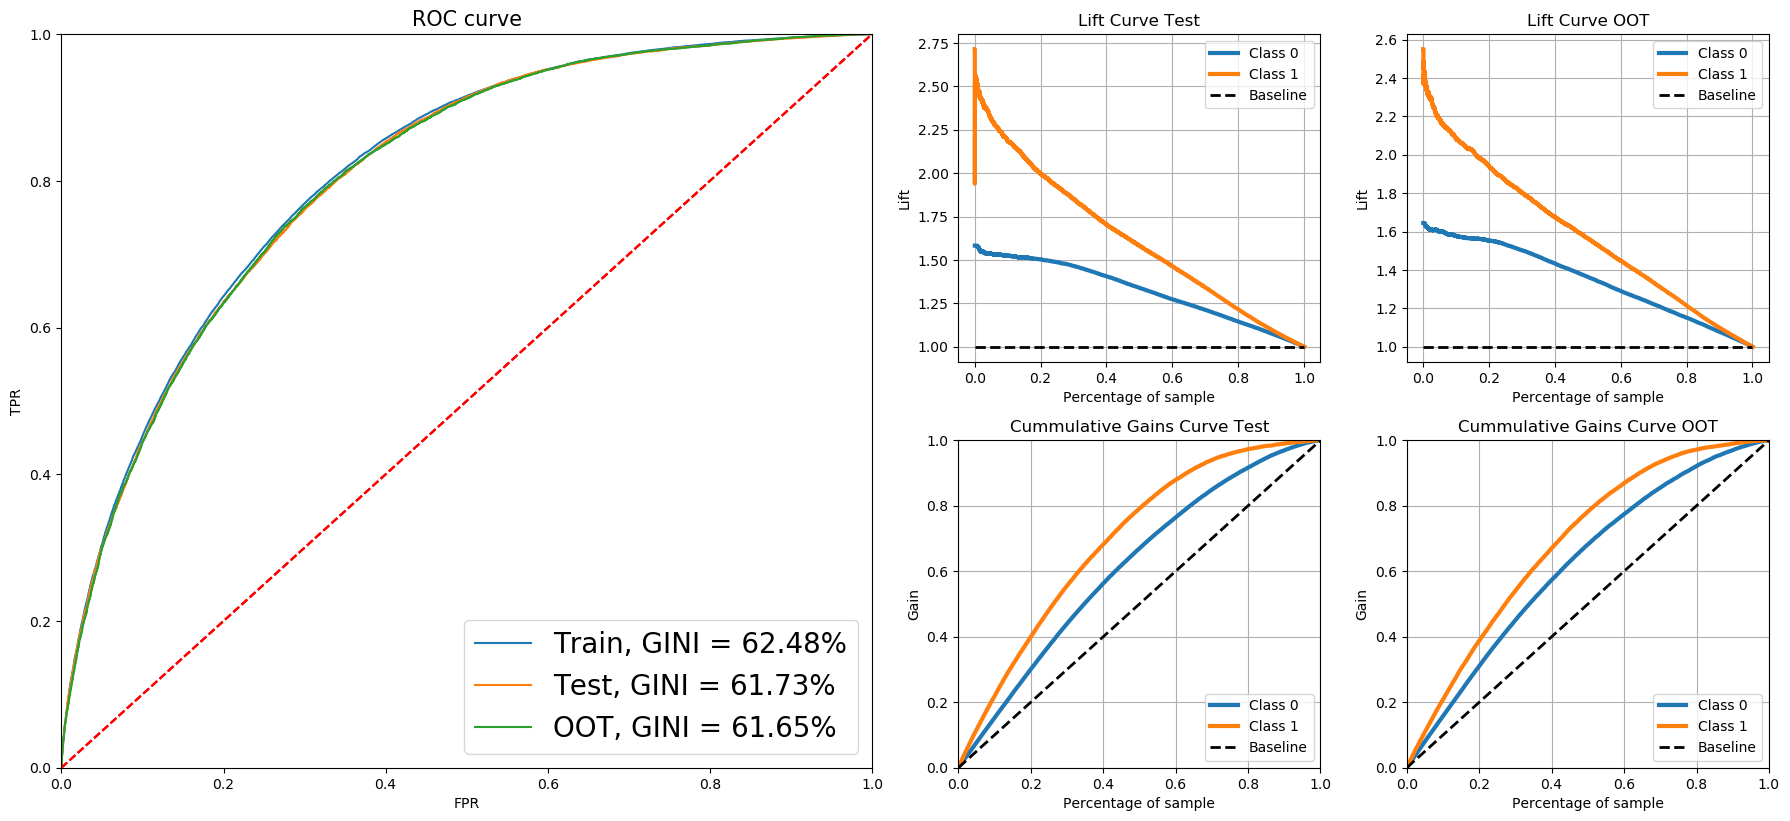

In [165]:
roc_lift_gain(model=model_logreg, 
              data = {'Train':[train_bin[features_corr], y_train], 
                      'Test':[test_bin[features_corr], y_test], 
                      'OOT':[oot_bin[features_corr], y_oot]})

In [167]:
train_lgbm, test_lgbm, y_train, y_test = data_preprocessing(train[features_corr],
                                                                      y_train,
                                                                      test[features_corr],
                                                                      y_test,
                                                                      necessary_fields,
                                                                      categorial_list=categories_bin,
                                                                      yeo_johnson=False,
                                                                      attribute_list=None,
                                                                      var_col=None,
                                                                      scale=False,
                                                                      median='median',
                                                                      check_percentile=5,
                                                                      high_outlier=None,
                                                                      low_outlier=None,
                                                                      cols_outlier=[],
                                                                      cut_non_out_9999=False)

train_lgbm, oot_lgbm,  y_train, y_oot = data_preprocessing(train[features_corr],
                                                                     y_train,
                                                                     oot[features_corr],
                                                                     y_oot,
                                                                     necessary_fields,
                                                                     categorial_list=categories_bin,
                                                                     yeo_johnson=False,
                                                                     attribute_list=None,
                                                                     var_col=None,
                                                                     scale=False,
                                                                     median='median',
                                                                     check_percentile=5,
                                                                     high_outlier=None,
                                                                     low_outlier=None,
                                                                     cols_outlier=[],
                                                                     cut_non_out_9999=False)

lightgbm_class = LGBMClassifier(**params_lgbm, verbosity=-1)
from datetime import datetime
print('Training started...', datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S"))
# train
default_model_lgbm = lightgbm_class.fit(train_lgbm[features_corr], y_train)
print('Training finished...', datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S"))

y_train_pred_lgbm = default_model_lgbm.predict_proba(train_lgbm[features_corr])[:, 1]
y_test_pred_lgbm = default_model_lgbm.predict_proba(test_lgbm[features_corr])[:, 1]
y_oot_pred_lgbm = default_model_lgbm.predict_proba(oot_lgbm[features_corr])[:, 1]

lgbm_stats = model_stats(clf=default_model_lgbm, data_dict={'Train': [train_lgbm[features_corr], y_train], 
                                                            'Test': [test_lgbm[features_corr], y_test], 
                                                            'OOT': [oot_lgbm[features_corr], y_oot]},
                        round_to = 5)

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Training started... 09.06.2022 01:52:04
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
Training finished... 09.06.2022 01:52:08


# Two Forest with correlation (CFSS)

In [598]:
deleted = pd.read_csv(os.path.join(PATH, 'Selection','deleted.csv'), sep=',', index_col=0)

In [607]:
col_forest = pd.read_csv(os.path.join(PATH, 'Datasets','train_for_forest.csv'), sep = '&', encoding = 'cp1251', nrows = 1)

In [615]:
col_all = list(col_forest.columns)

In [616]:
col_all.remove('Unnamed: 0')

In [617]:
deleted_all = deleted

In [600]:
deleted

deleted
SD                        ('Blacklist',)
MAX_DAYSOVERDUE_BF_CD     ('Blacklist',)
REGION_REG                ('Blacklist',)
MAX_DAYSOVERDUE_BF        ('Blacklist',)
DAYSOVERDUE_SD_CD         ('Blacklist',)
...                                  ...
C_CURPTPAMTALLL12M2LP12M   ('2forests',)
C_COUNTOFPAYMENTSL3M       ('2forests',)
C_SCHEDULE2FACTPAY3M       ('2forests',)
C_COUNTACTIVECONTRACTS          ('vif',)
C_SCHEDULE2FACTPAY3M_BIN        ('vif',)

[196 rows x 1 columns]

In [618]:
features_all = [x for x in col_all if x not in necessary_fields and x not in deleted_all.index ]

In [619]:
len(features_all)

31

In [620]:
new_meta_all= []

for combination in combination_preproc:
    outputs = list(combination)
    dicts = {}
    for position in range(len(combination)):
        dicts[list(params_preproc_grid.keys())[position]] = combination[position]

    non_outliers = attribute_list.loc[attribute_list[str(dicts['high_outlier'])+'%'] == attribute_list['1%'], 'attribute'].to_list()
    
    cols_outliers = [x for x in attribute_list if x not in non_outliers]

    print('-'*20, dicts, non_outliers, '-'*20)
    i_meta_all = find_meta_params(train[[*features_all, *sys_no_target]],
                               y_train,
                               params_dictionary,
                               params_to_model,
                               pass_model_logreg,
                               sort_by_var= sort_by_var.upper(),
                               list_of_vars_for_strat =[index_month],
                               n_folds=5,
                               second_target=None,
                               yeo_johnson=False,
                               attribute_list=None,
                               var_col=None,
                               categorial_list=categories_bin,
                               cols_outlier=cols_outliers,
                               need_business=False,
                               draw=True,
                               draw_by_approval_rate=False,
                               simple_b_score=None,
                               business_dict= None,
                               business_dict_sec=None,
                               scale='mean',
                               median='median',
                               high_outlier=dicts['high_outlier'],
                               low_outlier=dicts['low_outlier'],
                               check_percentile=1,
                               random_state=241,
                               task='binary',
                               k_logs=10,
                               cut_non_out_9999=True)
    i_meta_all['high_outlier'] = dicts['high_outlier']
    i_meta_all['low_outlier'] = dicts['low_outlier']
    new_meta_all.append(i_meta2)

i_meta_all['weight'] = round(i_meta_all['weight_0'], 5)

-------------------- {'high_outlier': 99, 'low_outlier': 1} [] --------------------
{'C': [0.05, 0.1, 0.2, 0.3, 0.5, 1, 1.5], 'weight_0': array([0.00291197, 0.00582395, 0.02911974, 0.05823948, 0.11647895,
       0.29119738, 0.58239477, 0.87359215]), 'regularization': ['l2'], 'random_state': [241], 'solver': ['liblinear'], 'max_iter': [300]}
-------------------- 12.06.2022 19:31:28 0 -------------------- 
 Параметры: {'C': 0.05, 'class_weight': {0: 0.002911973836514965, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.6473430389859234 
 Среднее значение AUC = 0.7880039339580165
-------------------- 12.06.2022 19:31:53 1 -------------------- 
 Параметры: {'C': 0.05, 'class_weight': {0: 0.00582394767302993, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.6479562602786373 
 Среднее значение AUC = 0.7904741369997188
-------------------- 12.06.2022 19:36:29 10 ------

In [621]:
params_dict = {'weight_0': 'class_weight', 'C': 'C', 'max_iter': 'max_iter'}
other_hyps = {'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
pass_model_logreg = LogisticRegression

print(50*'-', 'By AUC', 50*'-')
model_logreg, auc_scores, y_test_pred_logreg = train_model_receive_stats(train_bin[features_all],
                                                                         y_train,
                                                                         test_bin[features_all],
                                                                         y_test,
                                                                         meta=i_meta_all,
                                                                         
                                                                         by_var='AUC',
                                                                         params_dict=params_dict,
                                                                         other_hyperparams=other_hyps,
                                                                         pass_model=pass_model_logreg,
                                                                         need_business=False,
                                                                         simple_b_score=None,
                                                                         business_dict=None,
                                                                         printed=True,
                                                                         task='binary')


y_train_pred_logreg = model_logreg.predict_proba(train_bin[features_all])[:, 1]
y_oot_pred_logreg = model_logreg.predict_proba(oot_bin[features_all])[:, 1]

joblib.dump(model_logreg, os.path.join(PATH, 'Modeling','Logreg','model_logreg_all.dat'))
joblib.dump(scaler_bin, os.path.join(PATH, 'Modeling','Logreg','scaler_logreg_all.dat'))

-------------------------------------------------- By AUC --------------------------------------------------
{'class_weight': {0: 0.582394767302993, 1: 1}, 'C': 1.5, 'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
12.06.2022 20:03:08 start of logit fit
12.06.2022 20:03:11 end of logit fit
12.06.2022 20:03:12
-------------------- Statistics --------------------
Brier score =  0.18471508211328333
--------------------
AUC =  0.7981376611435774
AUC train = 0.8029967348135348
Gini =  0.5962753222871549
Gini train = 0.6059934696270697
Stability = 0.9839632804196794
Average precision score =  0.6772972789240498
---------- Treshold by F_score ----------
Accuracy =  0.6921879718460359
Score F1 =  0.6641830761043108
Precision =  0.5551131068372448
Recall =  0.8265943354570113
Approval rate =  0.5483518780924064


['D:/Share/01 -Risk Desc Science/COLLECTION/Allocation_2019_new/segment_31_60/Data Sets\\Modeling\\Logreg\\scaler_logreg_all.dat']

In [622]:
p_values = lr_test_all_features(model_logreg,
                                LogisticRegression,
                                train_bin[features_all],
                                y_train,
                                class_weight=model_logreg.get_params()['class_weight'],
                                whole_model=True)
p_values.sort_values(by='p_value', ascending=False, inplace=True)

Number of finished repetitions: 0 | time:  12.06.2022 20:03:12
Number of finished repetitions: 5 | time:  12.06.2022 20:03:50
Number of finished repetitions: 10 | time:  12.06.2022 20:04:28
Number of finished repetitions: 15 | time:  12.06.2022 20:05:06
Number of finished repetitions: 20 | time:  12.06.2022 20:05:44
Number of finished repetitions: 25 | time:  12.06.2022 20:06:22
Number of finished repetitions: 30 | time:  12.06.2022 20:07:00


In [623]:
p_values.to_csv(os.path.join(PATH, 'Selection','two_forest_p_values.csv'), sep = '&')

In [624]:
del_vars = p_values[p_values['p_value'] > 0.05]['Variable'].to_list()
if 'Intercept' in del_vars:
    del_vars.remove('Intercept')

In [625]:
survivors = [i for i in features_all if i not in del_vars]
columns = [x for x in survivors if x not in necessary_fields]
len(survivors)

28

In [626]:
new_meta_all= []

for combination in combination_preproc:
    outputs = list(combination)
    dicts = {}
    for position in range(len(combination)):
        dicts[list(params_preproc_grid.keys())[position]] = combination[position]

    non_outliers = attribute_list.loc[attribute_list[str(dicts['high_outlier'])+'%'] == attribute_list['1%'], 'attribute'].to_list()
    
    cols_outliers = [x for x in attribute_list if x not in non_outliers]

    print('-'*20, dicts, non_outliers, '-'*20)
    i_meta_all = find_meta_params(train[[*survivors, *sys_no_target]],
                               y_train,
                               params_dictionary,
                               params_to_model,
                               pass_model_logreg,
                               sort_by_var= sort_by_var.upper(),
                               list_of_vars_for_strat =[index_month],
                               n_folds=5,
                               second_target=None,
                               yeo_johnson=False,
                               attribute_list=None,
                               var_col=None,
                               categorial_list=categories_bin,
                               cols_outlier=cols_outliers,
                               need_business=False,
                               draw=True,
                               draw_by_approval_rate=False,
                               simple_b_score=None,
                               business_dict= None,
                               business_dict_sec=None,
                               scale='mean',
                               median='median',
                               high_outlier=dicts['high_outlier'],
                               low_outlier=dicts['low_outlier'],
                               check_percentile=1,
                               random_state=241,
                               task='binary',
                               k_logs=10,
                               cut_non_out_9999=True)
    i_meta_all['high_outlier'] = dicts['high_outlier']
    i_meta_all['low_outlier'] = dicts['low_outlier']
    new_meta_all.append(i_meta2)

i_meta_all['weight'] = round(i_meta_all['weight_0'], 5)

-------------------- {'high_outlier': 99, 'low_outlier': 1} [] --------------------
{'C': [0.05, 0.1, 0.2, 0.3, 0.5, 1, 1.5], 'weight_0': array([0.00291197, 0.00582395, 0.02911974, 0.05823948, 0.11647895,
       0.29119738, 0.58239477, 0.87359215]), 'regularization': ['l2'], 'random_state': [241], 'solver': ['liblinear'], 'max_iter': [300]}
-------------------- 12.06.2022 20:07:42 0 -------------------- 
 Параметры: {'C': 0.05, 'class_weight': {0: 0.002911973836514965, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.6479065440454389 
 Среднее значение AUC = 0.7881546525525798
-------------------- 12.06.2022 20:08:06 1 -------------------- 
 Параметры: {'C': 0.05, 'class_weight': {0: 0.00582394767302993, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.6483693593270232 
 Среднее значение AUC = 0.7906016432682346
-------------------- 12.06.2022 20:12:15 10 ------

In [627]:
params_dict = {'weight_0': 'class_weight', 'C': 'C', 'max_iter': 'max_iter'}
other_hyps = {'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
pass_model_logreg = LogisticRegression

print(50*'-', 'By AUC', 50*'-')
model_logreg, auc_scores, y_test_pred_logreg = train_model_receive_stats(train_bin[survivors],
                                                                         y_train,
                                                                         test_bin[survivors],
                                                                         y_test,
                                                                         meta=i_meta_all,
                                                                         
                                                                         by_var='AUC',
                                                                         params_dict=params_dict,
                                                                         other_hyperparams=other_hyps,
                                                                         pass_model=pass_model_logreg,
                                                                         need_business=False,
                                                                         simple_b_score=None,
                                                                         business_dict=None,
                                                                         printed=True,
                                                                         task='binary')


y_train_pred_logreg = model_logreg.predict_proba(train_bin[survivors])[:, 1]
y_oot_pred_logreg = model_logreg.predict_proba(oot_bin[survivors])[:, 1]

joblib.dump(model_logreg, os.path.join(PATH, 'Modeling','Logreg','model_logreg_forest.dat'))
joblib.dump(scaler_bin, os.path.join(PATH, 'Modeling','Logreg','scaler_logreg_forest.dat'))

-------------------------------------------------- By AUC --------------------------------------------------
{'class_weight': {0: 0.582394767302993, 1: 1}, 'C': 1.5, 'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
12.06.2022 20:36:25 start of logit fit
12.06.2022 20:36:28 end of logit fit
12.06.2022 20:36:28
-------------------- Statistics --------------------
Brier score =  0.18470888868010063
--------------------
AUC =  0.7981331219956791
AUC train = 0.8030172441430645
Gini =  0.5962662439913582
Gini train = 0.606034488286129
Stability = 0.9838817023064222
Average precision score =  0.6774280255537953
---------- Treshold by F_score ----------
Accuracy =  0.690840669934261
Score F1 =  0.6638207582914447
Precision =  0.5535894843276037
Recall =  0.8288651990159591
Approval rate =  0.5513716927222467


['D:/Share/01 -Risk Desc Science/COLLECTION/Allocation_2019_new/segment_31_60/Data Sets\\Modeling\\Logreg\\scaler_logreg_forest.dat']

In [628]:
logreg_stats = model_stats(clf=model_logreg, data_dict={'Train': [train_bin[survivors], y_train],
                                                        'Test': [test_bin[survivors], y_test], 
                                                        'OOT': [oot_bin[survivors], y_oot]},
                           round_to = 5)

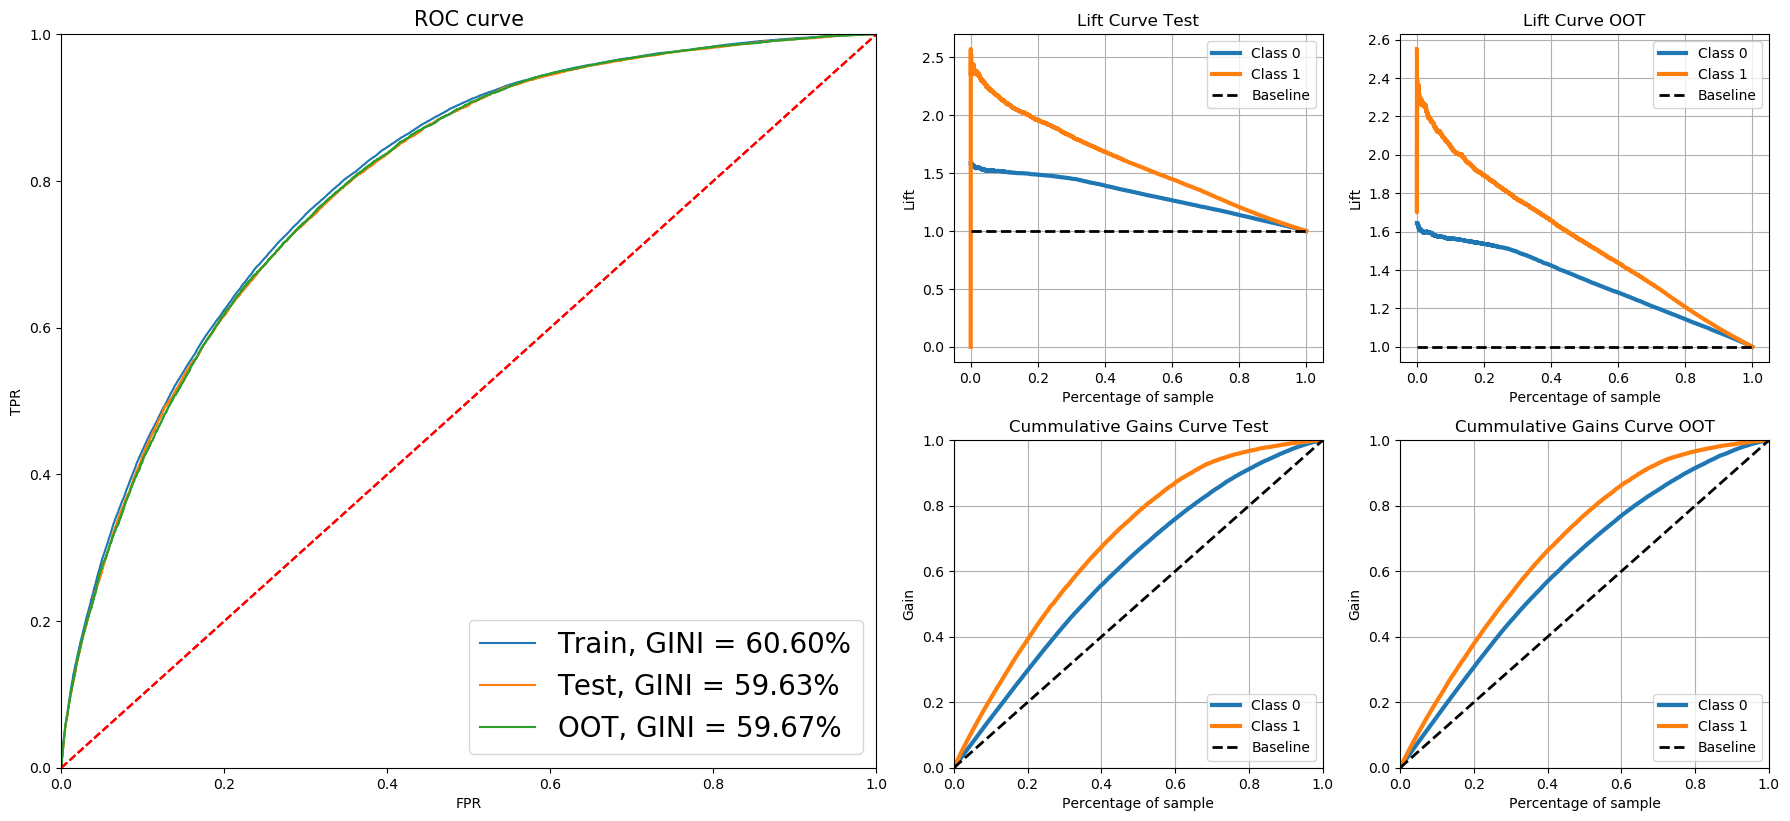

In [629]:
roc_lift_gain(model=model_logreg, 
              data = {'Train':[train_bin[survivors], y_train], 
                      'Test':[test_bin[survivors], y_test], 
                      'OOT':[oot_bin[survivors], y_oot]})

In [630]:
train_lgbm, test_lgbm, y_train, y_test = data_preprocessing(train[survivors],
                                                                      y_train,
                                                                      test[survivors],
                                                                      y_test,
                                                                      necessary_fields,
                                                                      categorial_list=categories_bin,
                                                                      yeo_johnson=False,
                                                                      attribute_list=None,
                                                                      var_col=None,
                                                                      scale=False,
                                                                      median='median',
                                                                      check_percentile=5,
                                                                      high_outlier=None,
                                                                      low_outlier=None,
                                                                      cols_outlier=[],
                                                                      cut_non_out_9999=False)

train_lgbm, oot_lgbm,  y_train, y_oot = data_preprocessing(train[survivors],
                                                                     y_train,
                                                                     oot[survivors],
                                                                     y_oot,
                                                                     necessary_fields,
                                                                     categorial_list=categories_bin,
                                                                     yeo_johnson=False,
                                                                     attribute_list=None,
                                                                     var_col=None,
                                                                     scale=False,
                                                                     median='median',
                                                                     check_percentile=5,
                                                                     high_outlier=None,
                                                                     low_outlier=None,
                                                                     cols_outlier=[],
                                                                     cut_non_out_9999=False)

lightgbm_class = LGBMClassifier(**params_lgbm, verbosity=-1)
from datetime import datetime
print('Training started...', datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S"))
# train
default_model_lgbm = lightgbm_class.fit(train_lgbm[survivors], y_train)
print('Training finished...', datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S"))

y_train_pred_lgbm = default_model_lgbm.predict_proba(train_lgbm[survivors])[:, 1]
y_test_pred_lgbm = default_model_lgbm.predict_proba(test_lgbm[survivors])[:, 1]
y_oot_pred_lgbm = default_model_lgbm.predict_proba(oot_lgbm[survivors])[:, 1]

lgbm_stats = model_stats(clf=default_model_lgbm, data_dict={'Train': [train_lgbm[survivors], y_train], 
                                                            'Test': [test_lgbm[survivors], y_test], 
                                                            'OOT': [oot_lgbm[survivors], y_oot]},
                        round_to = 5)

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training started... 12.06.2022 20:36:32
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
Training finished... 12.06.2022 20:36:33


# Experiment 2

In [502]:
list_of_vars_for_strat

['DATE_REPORT']

In [504]:
deleted_corr = deleted[(deleted != "('2forests',)")
                 & (deleted != "('vif',)")].dropna()

In [505]:
data_prepr =  pd.concat([train_bin[features_corr], y_train, train[['CIFID', 'DATE_REPORT']]], axis=1)

## 2.1 Gini Scheme 

In [506]:
X_1_2, X_2_2, y_1, y_2 = stratified_split(data_prepr, target, list_of_vars_for_strat, sort_by_var, 
                                      size_of_test = 0.5, drop_technical = True, random_state = 241)

In [508]:
from ml_pipeline import calculate_metrics_for_several_vars

In [509]:
print(30*'-', 'LogisticRegression', 30*'-')

logit_params = {'class_weight': {0: 2*w_b, 1:1}}
print(20*'-', 'First sample', 20*'-')

tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
print (20*'-', 'time: ' , tm, 20*'-')

first_logit_res = calculate_metrics_for_several_vars(X_1_2, y_1, X_2_2, y_2, list(X_1_2.columns), 
                                                     LogisticRegression, logit_params,
                                                     use_metrics = [metrics.roc_auc_score,
                                                                   metrics.average_precision_score],
                                                    names = ['roc_auc_score', 'average_precision_score'], 
                                                    task = 'binary', 
                                                     integral_metrics = [metrics.roc_auc_score,
                                                                         metrics.average_precision_score],
                                                    n_jobs = 3)

print(20*'-', 'Second sample', 20*'-')

tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
print (20*'-', 'time: ' , tm, 20*'-')

sec_logit_res = calculate_metrics_for_several_vars(X_2_2, y_2, X_1_2, y_1, list(X_2_2.columns), 
                                                     LogisticRegression, logit_params,
                                                     use_metrics = [metrics.roc_auc_score,
                                                                   metrics.average_precision_score],
                                                    names = ['roc_auc_score', 'average_precision_score'], 
                                                    task = 'binary', 
                                                     integral_metrics = [metrics.roc_auc_score,
                                                                         metrics.average_precision_score],
                                                    n_jobs = 3)


------------------------------ LogisticRegression ------------------------------
-------------------- First sample --------------------
-------------------- time:  11.06.2022 17:05:05 --------------------
-------------------- Second sample --------------------
-------------------- time:  11.06.2022 17:05:13 --------------------


In [511]:
first_logit_res1 = first_logit_res.pivot(index='Feature',columns='metric')['score']
sec_logit_res1 = sec_logit_res.pivot(index='Feature',columns='metric')['score']
first_logit_res1.reset_index(inplace = True)
sec_logit_res1.reset_index(inplace = True)

In [512]:
logit_all = pd.merge(first_logit_res1, sec_logit_res1, on = 'Feature', suffixes=('_1', '_2'))

In [513]:
metr = ['Gini_score', 'average_precision_score']
for i in metr:
    logit_all[i] = (logit_all[i+'_1']+logit_all[i+'_2'])/2

In [521]:
one_factor = logit_all[logit_all['Gini_score'] >= 0.05]['Feature'].to_list()
#one_factor = logit_all['Feature'].to_list()

In [524]:
logit_all.to_csv(os.path.join(PATH, 'Selection','one_factor.csv'), sep='&')

In [544]:
vif_del = []

In [545]:
vif = calculate_vif(data_prepr[one_factor])
vif.sort_values(by = 'VIF', ascending = False, inplace = True)

12.06.2022 00:46:05 0 CCDLOANRATE
12.06.2022 00:46:16 10 C_COUNTOFCC
12.06.2022 00:46:27 20 C_CURPTPAMTALLL1M2BT
12.06.2022 00:46:38 30 C_MAXDAYSTORPCALL12M
12.06.2022 00:46:50 40 C_SUMOFPAYMENTSL1M2L3M


In [547]:
vif = vif.sort_values(by = 'VIF', ascending = False).reset_index()
while vif['VIF'][0] > 10:
    print(vif.head(5))
    c = vif.Features[0]
    vif_del.append(c)
    print('Delete ', c)
    vif = calculate_vif(data[[c for c in imp_test if c not in vif_del]])
    vif = vif.sort_values(by = 'VIF', ascending = False).reset_index()

   level_0  index                    Features        VIF
0        0     37    C_SCHEDULE2FACTPAY3M_BIN  19.131847
1        1     41  C_SUMOFPAYMENTSL1M2L3M_BIN  16.196688
2        2     12                 C_COUNTOFIL  11.572257
3        3     11                 C_COUNTOFGP   8.866892
4        4     10                 C_COUNTOFCC   8.235240
Delete  C_SCHEDULE2FACTPAY3M_BIN
12.06.2022 00:48:01 0 C_COUNTDAYSCALLL1M
12.06.2022 00:48:20 10 C_SUMOFPAYMENTSL1M2L3M
12.06.2022 00:48:39 20 C_BALANCETOTAL
12.06.2022 00:48:59 30 C_COUNTOFTPCL1M
12.06.2022 00:49:18 40 C_DAYSBETWLASTDELINQS12M
12.06.2022 00:49:38 50 C_COUNTOPERATORCALLL3M
12.06.2022 00:49:57 60 C_SCHEDULE2FACTPAY12M
12.06.2022 00:50:17 70 C_CURPTPAMTALLL1M2LP12M
   index                       Features           VIF
0     12         C_DAYSINDELINQUENCYL6M  3.002400e+15
1     11  C_PERCENTDAYSINDELINQUENCYL6M  1.801440e+15
2     29  C_PERCENTDAYSINDELINQUENCYL3M  1.801440e+15
3     21         C_DAYSINDELINQUENCYL3M  1.286743e+15
4    

C:\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning:

divide by zero encountered in double_scalars



12.06.2022 00:53:15 20 C_CURPTPAMTALLL12M2BT
12.06.2022 00:53:34 30 C_BALANCEPRINCIPLE
12.06.2022 00:53:53 40 C_COUNTOFRPCALLL7D
12.06.2022 00:54:12 50 C_SUMOFPAYMENTSL12M2TD
12.06.2022 00:54:31 60 C_AVGDAYSL3MTOL6M
   index                       Features          VIF
0     27  C_PERCENTDAYSINDELINQUENCYL3M          inf
1     19         C_DAYSINDELINQUENCYL3M          inf
2     18                 C_BALANCETOTAL  4652.280725
3     30             C_BALANCEPRINCIPLE  4564.934774
4      1             C_COUNTDAYSCALLL7D  1246.450921
Delete  C_PERCENTDAYSINDELINQUENCYL3M
12.06.2022 00:54:51 0 C_COUNTDAYSCALLL1M
12.06.2022 00:55:09 10 C_PERCENTDAYSINDELINQUENCYL6M
12.06.2022 00:55:28 20 C_CURPTPAMTALLL12M2BT
12.06.2022 00:55:46 30 C_COUNTACTIVECONTRACTS
12.06.2022 00:56:05 40 C_MAXDAYSINDELINQUENCYL3M
12.06.2022 00:56:23 50 C_PTPAMOUNTSUMALLL6M
12.06.2022 00:56:42 60 C_SUMOFPAYMENTSL3M2L6M
   index                  Features          VIF
0     18            C_BALANCETOTAL  4652.215728
1     29

In [548]:
print(len(vif_del))
vif_del

21


['C_SCHEDULE2FACTPAY3M_BIN',
 'C_SCHEDULE2FACTPAY3M_BIN',
 'C_DAYSINDELINQUENCYL6M',
 'C_DAYSINDELINQUENCYL12M',
 'C_PERCENTDAYSINDELINQUENCYL3M',
 'C_BALANCETOTAL',
 'C_COUNTDAYSCALLL7D',
 'C_COUNTDAYSCALLL1M',
 'C_COUNTDAYSTASKL3M_NEWLOG',
 'C_COUNTDAYSTASKL7D_NEWLOG',
 'C_PERCENTDAYSINDELINQUENCYL6M',
 'C_AVGDAYSINDELINQUENCYL3M',
 'C_COUNTDELINQ00L6M',
 'C_AVGDAYSINDELINQUENCYL6M',
 'C_PTPAMOUNTSUMALLL6M',
 'C_PERCENTDAYSINDELINQUENCYL12M',
 'C_MAXDAYSINDELINQUENCYL6M',
 'C_SUMOFPAYMENTSL6M2TD',
 'C_SUMOFPAYMENTSL12M',
 'C_AVGDAYSL3MTOL12M_NEWLOG',
 'C_PTPAMOUNTSUMALLL3M']

In [549]:
survivors = [i for i in one_factor if i not in vif_del]
columns = [x for x in survivors if x not in necessary_fields]

In [550]:
len(survivors)

44

In [551]:
pd.DataFrame(vif_del).to_csv(os.path.join(PATH, 'Selection','one_factor_vif_del.csv'))
print(survivors)

['CCDLOANRATE', 'C_BALANCEOVERDUE', 'C_BALANCEOVERDUESHARE', 'C_BROKENPTPSHAREALLL12M', 'C_BROKENPTPSHAREALLL1M', 'C_COUNTACTIVECONTRACTS', 'C_COUNTALLCONTRACTS', 'C_COUNTDAYSPTPTOPAYALL', 'C_COUNTDELINQ00L12M', 'C_COUNTOFCC', 'C_COUNTOFGP', 'C_COUNTOFIL', 'C_COUNTOFPAYMENTSL3M', 'C_COUNTOFPTPALLL1M', 'C_COUNTOFPTPALLL7D', 'C_COUNTOFRPCALLL7D', 'C_COUNTOFTPCL1M', 'C_COUNTOPERATORCALLL1M', 'C_CURPTPAMTALLL12M2BO', 'C_CURPTPAMTALLL1M2BT', 'C_CURPTPAMTALLL3M2BT', 'C_DAYSBETWLASTDELINQS12M', 'C_DAYSINDELINQUENCYL3M', 'C_DAYSSINCELASTPAYMENT12M', 'C_DAYSSINCELASTRPCALL12M', 'C_DAYSSINCELASTTPC12M', 'C_DAYSSINCELASTTPC12M_BIN', 'C_LASTDELINQLENGTH12M', 'C_LASTPAYMENTAMOUNT', 'C_MAXDAYSTORPCALL12M', 'C_MONTHSINCEFIRSTCREDIT', 'C_PAYL3MTOL6M', 'C_PTPAMOUNTSUMALLL7D', 'C_REPAIDSHARE', 'C_SCHEDULE2FACTPAY1M', 'C_SCHEDULE2FACTPAY3M', 'C_SUMOFPAYMENTSL1M', 'C_SUMOFPAYMENTSL1M2L3M', 'C_SUMOFPAYMENTSL1M2L3M_BIN', 'C_SUMOFPAYMENTSL1M2TD', 'C_SUMPAIDDEBT', 'EMPINCOMEAMT', 'EMPINCOMEAMT_BIN', 'MONTH_DI

In [552]:
new_meta_one= []

for combination in combination_preproc:
    outputs = list(combination)
    dicts = {}
    for position in range(len(combination)):
        dicts[list(params_preproc_grid.keys())[position]] = combination[position]

    non_outliers = attribute_list.loc[attribute_list[str(dicts['high_outlier'])+'%'] == attribute_list['1%'], 'attribute'].to_list()
    
    cols_outliers = [x for x in attribute_list if x not in non_outliers]

    print('-'*20, dicts, non_outliers, '-'*20)
    i_meta_one = find_meta_params(train[[*survivors, *sys_no_target]],
                               y_train,
                               params_dictionary,
                               params_to_model,
                               pass_model_logreg,
                               sort_by_var= sort_by_var.upper(),
                               list_of_vars_for_strat =[index_month],
                               n_folds=5,
                               second_target=None,
                               yeo_johnson=False,
                               attribute_list=None,
                               var_col=None,
                               categorial_list=categories_bin,
                               cols_outlier=cols_outliers,
                               need_business=False,
                               draw=True,
                               draw_by_approval_rate=False,
                               simple_b_score=None,
                               business_dict= None,
                               business_dict_sec=None,
                               scale='mean',
                               median='median',
                               high_outlier=dicts['high_outlier'],
                               low_outlier=dicts['low_outlier'],
                               check_percentile=1,
                               random_state=241,
                               task='binary',
                               k_logs=10,
                               cut_non_out_9999=True)
    i_meta_one['high_outlier'] = dicts['high_outlier']
    i_meta_one['low_outlier'] = dicts['low_outlier']
    new_meta_all.append(i_meta_one)

i_meta_one['weight'] = round(i_meta_one['weight_0'], 5)

-------------------- {'high_outlier': 99, 'low_outlier': 1} [] --------------------
{'C': [0.05, 0.1, 0.2, 0.3, 0.5, 1, 1.5], 'weight_0': array([0.00291197, 0.00582395, 0.02911974, 0.05823948, 0.11647895,
       0.29119738, 0.58239477, 0.87359215]), 'regularization': ['l2'], 'random_state': [241], 'solver': ['liblinear'], 'max_iter': [300]}
-------------------- 12.06.2022 01:24:31 0 -------------------- 
 Параметры: {'C': 0.05, 'class_weight': {0: 0.002911973836514965, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.657876953333411 
 Среднее значение AUC = 0.777745800736535
-------------------- 12.06.2022 01:25:08 1 -------------------- 
 Параметры: {'C': 0.05, 'class_weight': {0: 0.00582394767302993, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.6583615179588065 
 Среднее значение AUC = 0.7824726301385536
-------------------- 12.06.2022 01:32:33 10 --------

In [553]:
params_dict = {'weight_0': 'class_weight', 'C': 'C', 'max_iter': 'max_iter'}
other_hyps = {'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
pass_model_logreg = LogisticRegression

print(50*'-', 'By AUC', 50*'-')
model_logreg, auc_scores, y_test_pred_logreg = train_model_receive_stats(train_bin[survivors],
                                                                         y_train,
                                                                         test_bin[survivors],
                                                                         y_test,
                                                                         meta=i_meta_one,
                                                                         by_var='AUC',
                                                                         params_dict=params_dict,
                                                                         other_hyperparams=other_hyps,
                                                                         pass_model=pass_model_logreg,
                                                                         need_business=False,
                                                                         simple_b_score=None,
                                                                         business_dict=None,
                                                                         printed=True,
                                                                         task='binary')


y_train_pred_logreg = model_logreg.predict_proba(train_bin[survivors])[:, 1]
y_oot_pred_logreg = model_logreg.predict_proba(oot_bin[survivors])[:, 1]

joblib.dump(model_logreg, os.path.join(PATH, 'Modeling','Logreg','model_logreg_one_select.dat'))
joblib.dump(scaler_bin, os.path.join(PATH, 'Modeling','Logreg','scaler_logreg_one_select.dat'))

-------------------------------------------------- By AUC --------------------------------------------------
{'class_weight': {0: 0.582394767302993, 1: 1}, 'C': 1.5, 'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
12.06.2022 02:18:32 start of logit fit
12.06.2022 02:18:38 end of logit fit
12.06.2022 02:18:38
-------------------- Statistics --------------------
Brier score =  0.18675944851299575
--------------------
AUC =  0.792767610277195
AUC train = 0.7977825693673943
Gini =  0.58553522055439
Gini train = 0.5955651387347887
Stability = 0.983158990464576
Average precision score =  0.6788857400299477
---------- Treshold by F_score ----------
Accuracy =  0.7018049199749123
Score F1 =  0.6628319281380506
Precision =  0.5678667866786679
Recall =  0.7959376774112156
Approval rate =  0.5161560082696462


['D:/Share/01 -Risk Desc Science/COLLECTION/Allocation_2019_new/segment_31_60/Data Sets\\Modeling\\Logreg\\scaler_logreg_one_select.dat']

In [554]:
p_values = lr_test_all_features(model_logreg,
                                LogisticRegression,
                                train_bin[survivors],
                                y_train,
                                class_weight=model_logreg.get_params()['class_weight'],
                                whole_model=True)
p_values.sort_values(by='p_value', ascending=False, inplace=True)

Number of finished repetitions: 0 | time:  12.06.2022 02:18:39
Number of finished repetitions: 5 | time:  12.06.2022 02:19:47
Number of finished repetitions: 10 | time:  12.06.2022 02:20:53
Number of finished repetitions: 15 | time:  12.06.2022 02:21:59
Number of finished repetitions: 20 | time:  12.06.2022 02:23:08
Number of finished repetitions: 25 | time:  12.06.2022 02:24:17
Number of finished repetitions: 30 | time:  12.06.2022 02:25:24
Number of finished repetitions: 35 | time:  12.06.2022 02:26:30
Number of finished repetitions: 40 | time:  12.06.2022 02:27:38


In [555]:
p_values.to_csv(os.path.join(PATH, 'Selection','one_select_p_values.csv'), sep = '&')

In [556]:
del_vars = p_values[p_values['p_value'] > 0.05]['Variable'].to_list()
if 'Intercept' in del_vars:
    del_vars.remove('Intercept')

In [557]:
del_vars

['C_COUNTOFTPCL1M',
 'C_MONTHSINCEFIRSTCREDIT',
 'C_SUMOFPAYMENTSL1M',
 'C_MAXDAYSTORPCALL12M',
 'C_LASTDELINQLENGTH12M']

In [558]:
survivors = [i for i in survivors if i not in del_vars]
columns = [x for x in survivors if x not in necessary_fields]
len(survivors)

39

### Final train (selection with p-value)

In [559]:
new_meta_one_pval= []

for combination in combination_preproc:
    outputs = list(combination)
    dicts = {}
    for position in range(len(combination)):
        dicts[list(params_preproc_grid.keys())[position]] = combination[position]

    non_outliers = attribute_list.loc[attribute_list[str(dicts['high_outlier'])+'%'] == attribute_list['1%'], 'attribute'].to_list()
    
    cols_outliers = [x for x in attribute_list if x not in non_outliers]

    print('-'*20, dicts, non_outliers, '-'*20)
    i_meta_one_pval = find_meta_params(train[[*survivors, *sys_no_target]],
                               y_train,
                               params_dictionary,
                               params_to_model,
                               pass_model_logreg,
                               sort_by_var= sort_by_var.upper(),
                               list_of_vars_for_strat =[index_month],
                               n_folds=5,
                               second_target=None,
                               yeo_johnson=False,
                               attribute_list=None,
                               var_col=None,
                               categorial_list=categories_bin,
                               cols_outlier=cols_outliers,
                               need_business=False,
                               draw=True,
                               draw_by_approval_rate=False,
                               simple_b_score=None,
                               business_dict= None,
                               business_dict_sec=None,
                               scale='mean',
                               median='median',
                               high_outlier=dicts['high_outlier'],
                               low_outlier=dicts['low_outlier'],
                               check_percentile=1,
                               random_state=241,
                               task='binary',
                               k_logs=10,
                               cut_non_out_9999=True)
    i_meta_one_pval['high_outlier'] = dicts['high_outlier']
    i_meta_one_pval['low_outlier'] = dicts['low_outlier']
    new_meta_one_pval.append(i_meta_one_pval)

i_meta_one_pval['weight'] = round(i_meta_one_pval['weight_0'], 5)

-------------------- {'high_outlier': 99, 'low_outlier': 1} [] --------------------
{'C': [0.05, 0.1, 0.2, 0.3, 0.5, 1, 1.5], 'weight_0': array([0.00291197, 0.00582395, 0.02911974, 0.05823948, 0.11647895,
       0.29119738, 0.58239477, 0.87359215]), 'regularization': ['l2'], 'random_state': [241], 'solver': ['liblinear'], 'max_iter': [300]}
-------------------- 12.06.2022 02:29:24 0 -------------------- 
 Параметры: {'C': 0.05, 'class_weight': {0: 0.002911973836514965, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.6583009281722216 
 Среднее значение AUC = 0.7780155513302017
-------------------- 12.06.2022 02:29:58 1 -------------------- 
 Параметры: {'C': 0.05, 'class_weight': {0: 0.00582394767302993, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.6586529811340949 
 Среднее значение AUC = 0.7826648746614646
-------------------- 12.06.2022 02:36:25 10 ------

In [560]:
params_dict = {'weight_0': 'class_weight', 'C': 'C', 'max_iter': 'max_iter'}
other_hyps = {'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
pass_model_logreg = LogisticRegression

print(50*'-', 'By AUC', 50*'-')
model_logreg, auc_scores, y_test_pred_logreg = train_model_receive_stats(train_bin[survivors],
                                                                         y_train,
                                                                         test_bin[survivors],
                                                                         y_test,
                                                                         meta=i_meta_one_pval,
                                                                         by_var='AUC',
                                                                         params_dict=params_dict,
                                                                         other_hyperparams=other_hyps,
                                                                         pass_model=pass_model_logreg,
                                                                         need_business=False,
                                                                         simple_b_score=None,
                                                                         business_dict=None,
                                                                         printed=True,
                                                                         task='binary')


y_train_pred_logreg = model_logreg.predict_proba(train_bin[survivors])[:, 1]
y_oot_pred_logreg = model_logreg.predict_proba(oot_bin[survivors])[:, 1]

joblib.dump(model_logreg, os.path.join(PATH, 'Modeling','Logreg','model_logreg_one_select.dat'))
joblib.dump(scaler_bin, os.path.join(PATH, 'Modeling','Logreg','scaler_logreg_one_select.dat'))

-------------------------------------------------- By AUC --------------------------------------------------
{'class_weight': {0: 0.582394767302993, 1: 1}, 'C': 1.5, 'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
12.06.2022 03:16:33 start of logit fit
12.06.2022 03:16:39 end of logit fit
12.06.2022 03:16:39
-------------------- Statistics --------------------
Brier score =  0.1867463948814967
--------------------
AUC =  0.7927935300409994
AUC train = 0.7977633549398924
Gini =  0.5855870600819988
Gini train = 0.5955267098797847
Stability = 0.983309481114974
Average precision score =  0.6789055605311143
---------- Treshold by F_score ----------
Accuracy =  0.6962298775813608
Score F1 =  0.6620842915837618
Precision =  0.5607546178762146
Recall =  0.8081120292689081
Approval rate =  0.5306975771794932


['D:/Share/01 -Risk Desc Science/COLLECTION/Allocation_2019_new/segment_31_60/Data Sets\\Modeling\\Logreg\\scaler_logreg_one_select.dat']

In [561]:
logreg_stats = model_stats(clf=model_logreg, data_dict={'Train': [train_bin[survivors], y_train],
                                                        'Test': [test_bin[survivors], y_test], 
                                                        'OOT': [oot_bin[survivors], y_oot]},
                           round_to = 5)

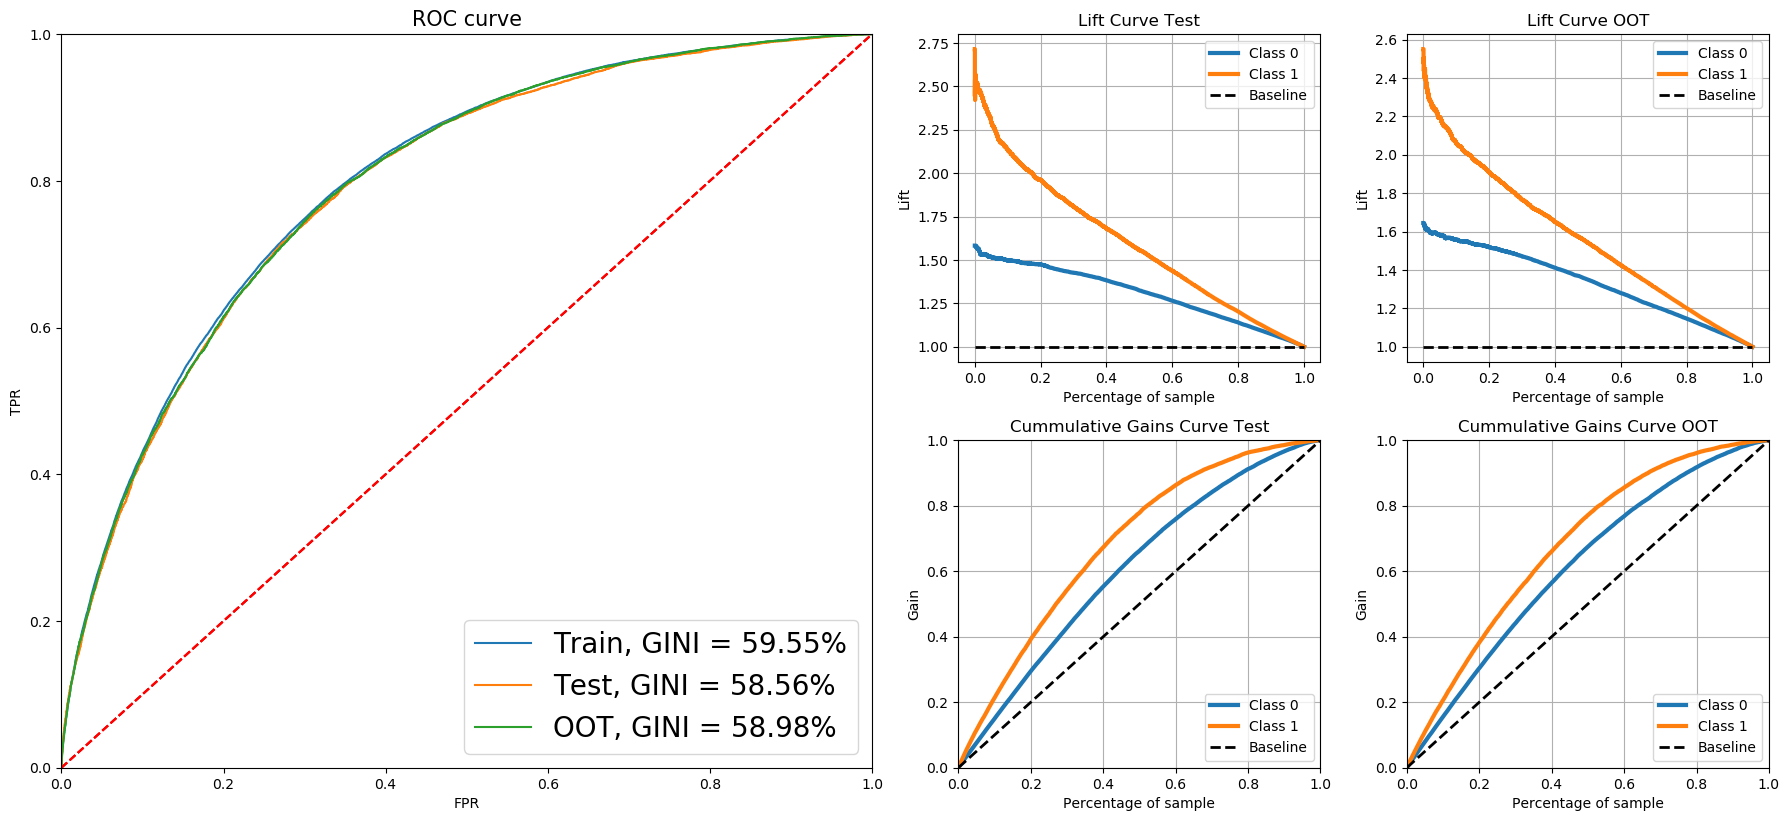

In [562]:
roc_lift_gain(model=model_logreg, 
              data = {'Train':[train_bin[survivors], y_train], 
                      'Test':[test_bin[survivors], y_test], 
                      'OOT':[oot_bin[survivors], y_oot]})

In [564]:
train_lgbm, test_lgbm, y_train, y_test = data_preprocessing(train[survivors],
                                                                      y_train,
                                                                      test[survivors],
                                                                      y_test,
                                                                      necessary_fields,
                                                                      categorial_list=categories_bin,
                                                                      yeo_johnson=False,
                                                                      attribute_list=None,
                                                                      var_col=None,
                                                                      scale=False,
                                                                      median='median',
                                                                      check_percentile=5,
                                                                      high_outlier=None,
                                                                      low_outlier=None,
                                                                      cols_outlier=[],
                                                                      cut_non_out_9999=False)

train_lgbm, oot_lgbm,  y_train, y_oot = data_preprocessing(train[survivors],
                                                                     y_train,
                                                                     oot[survivors],
                                                                     y_oot,
                                                                     necessary_fields,
                                                                     categorial_list=categories_bin,
                                                                     yeo_johnson=False,
                                                                     attribute_list=None,
                                                                     var_col=None,
                                                                     scale=False,
                                                                     median='median',
                                                                     check_percentile=5,
                                                                     high_outlier=None,
                                                                     low_outlier=None,
                                                                     cols_outlier=[],
                                                                     cut_non_out_9999=False)

lightgbm_class = LGBMClassifier(**params_lgbm, verbosity=-1)
from datetime import datetime
print('Training started...', datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S"))
# train
default_model_lgbm = lightgbm_class.fit(train_lgbm[survivors], y_train)
print('Training finished...', datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S"))

y_train_pred_lgbm = default_model_lgbm.predict_proba(train_lgbm[survivors])[:, 1]
y_test_pred_lgbm = default_model_lgbm.predict_proba(test_lgbm[survivors])[:, 1]
y_oot_pred_lgbm = default_model_lgbm.predict_proba(oot_lgbm[survivors])[:, 1]

lgbm_stats = model_stats(clf=default_model_lgbm, data_dict={'Train': [train_lgbm[survivors], y_train], 
                                                            'Test': [test_lgbm[survivors], y_test], 
                                                            'OOT': [oot_lgbm[survivors], y_oot]},
                        round_to = 5)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Training started... 12.06.2022 14:03:17
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
Training finished... 12.06.2022 14:03:18


## 2.2 Forward Scheme  

In [565]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
lr = LogisticRegression(class_weight = {0: w_b, 1:1}, max_iter = 300, C = 0.5, solver = 'liblinear', penalty = 'l2')

C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [567]:
sfs1 = SFS(lr, 
           k_features= 'best', 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           n_jobs = 3,
           cv=2)

sfs1 = sfs1.fit(train_bin[features_corr], y_train)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    9.3s
[Parallel(n_jobs=3)]: Done  89 out of  89 | elapsed:   13.2s finished

[2022-06-12 14:04:45] Features: 1/89 -- score: 0.7130554484710994[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done  88 out of  88 | elapsed:    7.5s finished

[2022-06-12 14:04:53] Features: 2/89 -- score: 0.7497792221024572[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    3.7s
[Parallel(n_jobs=3)]: Done  87 out of  87 | elapsed:    8.8s finished

[2022-06-12 14:05:02] Features: 3/89 -- score: 0.7627993578011645[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    3.9s
[Parallel(n_jobs=3)]: Done  86 out of  86 | elap

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   52.9s
[Parallel(n_jobs=3)]: Done  59 out of  59 | elapsed:  1.5min finished

[2022-06-12 14:28:17] Features: 31/89 -- score: 0.8030944668774918[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   53.6s
[Parallel(n_jobs=3)]: Done  58 out of  58 | elapsed:  1.5min finished

[2022-06-12 14:29:45] Features: 32/89 -- score: 0.8032675788749488[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   56.2s
[Parallel(n_jobs=3)]: Done  57 out of  57 | elapsed:  1.5min finished

[2022-06-12 14:31:15] Features: 33/89 -- score: 0.8034363711511163[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   56.3s
[Parallel(n_jobs=3)]: Done  56 out of  56 | elapsed:  1.5min finished

[2022-06-12 14:32:44] Features: 34/89 -- score: 0

[Parallel(n_jobs=3)]: Done  26 out of  26 | elapsed:  1.8min finished

[2022-06-12 15:23:53] Features: 64/89 -- score: 0.8047521004374516[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:  1.7min finished

[2022-06-12 15:25:39] Features: 65/89 -- score: 0.8047311571070744[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:  1.7min finished

[2022-06-12 15:27:21] Features: 66/89 -- score: 0.8047194108270431[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  23 out of  23 | elapsed:  1.7min finished

[2022-06-12 15:29:01] Features: 67/89 -- score: 0.8046857526484662[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  22 out of  22 | elapsed:  1.7min finished

[2022-06-12 15:30:45] Features: 68/89 -- score: 0.8047530066949808[Parallel(n_job

In [568]:
sfs1.k_feature_names_

('C_BALANCEOVERDUE',
 'C_BALANCEOVERDUESHARE',
 'C_MAXDAYSOVERDUEEVER',
 'C_COUNTACTIVECONTRACTS',
 'C_REPAIDSHARE',
 'C_COUNTDELINQ00L12M',
 'C_COUNTDELINQ30L12M',
 'C_DAYSINDELINQUENCYL1M',
 'C_DAYSSINCELASTDELINQUENCY12M',
 'C_LASTDELINQLENGTH12M',
 'C_AVGDAYSL3MTOL6M',
 'C_COUNTOFPAYMENTSL3M',
 'C_SUMOFPAYMENTSL1M',
 'C_SUMOFPAYMENTSL12M',
 'C_DAYSSINCELASTPAYMENT12M',
 'C_PAYL3MTOL6M',
 'C_SUMOFPAYMENTSL1M2L3M',
 'C_COUNTOFPAYMENTS100L12M',
 'C_SUMOFPAYMENTSL1M2TD',
 'C_SUMOFPAYMENTSL6M2TD',
 'C_COUNTOFCC',
 'C_COUNTOFGP',
 'C_COUNTOFRPCALLL12M',
 'C_COUNTOFRPCALLL7D',
 'C_CURPTPAMTALLL12M2LP12M',
 'C_CURPTPAMTALLL3M2BT',
 'C_CURPTPAMTALLL1M2BT',
 'C_CURPTPAMTALLL12M2BO',
 'C_COUNTDAYSPTPTOPAYALL',
 'C_COUNTOFNOTBROKENPTPL12M',
 'C_DAYSSINCELASTPTPNOTBR12M',
 'C_BROKENPTPSHAREALLL1M',
 'C_PTPNB2PTPALLL3M',
 'C_PTPNB2PTPALLL1M',
 'C_SCHEDULE2FACTPAY12M',
 'C_COUNTDAYSTASKL7D_NEWLOG',
 'C_COUNTOPERATORCALLL1M',
 'EMPINCOMEAMT',
 'CCDLOANRATE',
 'C_MAXDAYSTORPCALL12M',
 'C_MINDAYSTOR

In [569]:
forward_col = list(sfs1.k_feature_names_)
len(forward_col)

58

In [571]:
len(features_corr)

89

In [572]:
pd.DataFrame(sfs1.k_feature_names_).to_csv(os.path.join(PATH, 'Selection','forward.csv'), sep='&')

In [573]:
vif_del = []

In [574]:
vif = calculate_vif(data_prepr[forward_col])
vif.sort_values(by = 'VIF', ascending = False, inplace = True)

12.06.2022 16:16:23 0 C_BALANCEOVERDUE
12.06.2022 16:16:38 10 C_AVGDAYSL3MTOL6M
12.06.2022 16:16:52 20 C_COUNTOFCC
12.06.2022 16:17:07 30 C_DAYSSINCELASTPTPNOTBR12M
12.06.2022 16:17:22 40 C_MINDAYSTORPCALL12M
12.06.2022 16:17:36 50 EMPINDUSTRY_25.0


In [575]:
vif = vif.sort_values(by = 'VIF', ascending = False).reset_index()
while vif['VIF'][0] > 10:
    print(vif.head(5))
    c = vif.Features[0]
    vif_del.append(c)
    print('Delete ', c)
    vif = calculate_vif(data[[c for c in imp_test if c not in vif_del]])
    vif = vif.sort_values(by = 'VIF', ascending = False).reset_index()

   index                   Features        VIF
0     41       C_COUNTDELINQ30L1M_1  43.300996
1     55   C_SCHEDULE2FACTPAY3M_BIN  32.413856
2     57   C_MAXDAYSTORPCALL12M_BIN  10.492269
3     56           EMPINCOMEAMT_BIN   8.663184
4     53  C_DAYSSINCELASTTPC12M_BIN   7.352469
Delete  C_COUNTDELINQ30L1M_1
12.06.2022 16:17:49 0 C_COUNTDAYSCALLL1M
12.06.2022 16:18:09 10 C_SUMOFPAYMENTSL1M2L3M
12.06.2022 16:18:29 20 C_BALANCETOTAL
12.06.2022 16:18:48 30 C_COUNTOFTPCL1M
12.06.2022 16:19:08 40 C_DAYSBETWLASTDELINQS12M
12.06.2022 16:19:27 50 C_COUNTOPERATORCALLL3M
12.06.2022 16:19:46 60 C_SCHEDULE2FACTPAY12M
12.06.2022 16:20:06 70 C_CURPTPAMTALLL1M2LP12M
   index                       Features           VIF
0     12         C_DAYSINDELINQUENCYL6M  3.002400e+15
1     11  C_PERCENTDAYSINDELINQUENCYL6M  1.801440e+15
2     29  C_PERCENTDAYSINDELINQUENCYL3M  1.801440e+15
3     21         C_DAYSINDELINQUENCYL3M  1.286743e+15
4      2        C_DAYSINDELINQUENCYL12M  1.000800e+15
Delete  C_DAYSI

C:\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning:

divide by zero encountered in double_scalars



12.06.2022 16:23:04 20 C_CURPTPAMTALLL12M2BT
12.06.2022 16:23:22 30 C_BALANCEPRINCIPLE
12.06.2022 16:23:41 40 C_COUNTOFRPCALLL7D
12.06.2022 16:24:00 50 C_SUMOFPAYMENTSL12M2TD
12.06.2022 16:24:19 60 C_AVGDAYSL3MTOL6M
   index                       Features          VIF
0     27  C_PERCENTDAYSINDELINQUENCYL3M          inf
1     19         C_DAYSINDELINQUENCYL3M          inf
2     18                 C_BALANCETOTAL  4652.280725
3     30             C_BALANCEPRINCIPLE  4564.934774
4      1             C_COUNTDAYSCALLL7D  1246.450921
Delete  C_PERCENTDAYSINDELINQUENCYL3M
12.06.2022 16:24:39 0 C_COUNTDAYSCALLL1M
12.06.2022 16:24:58 10 C_PERCENTDAYSINDELINQUENCYL6M
12.06.2022 16:25:17 20 C_CURPTPAMTALLL12M2BT
12.06.2022 16:25:35 30 C_COUNTACTIVECONTRACTS
12.06.2022 16:25:54 40 C_MAXDAYSINDELINQUENCYL3M
12.06.2022 16:26:12 50 C_PTPAMOUNTSUMALLL6M
12.06.2022 16:26:31 60 C_SUMOFPAYMENTSL3M2L6M
   index                  Features          VIF
0     18            C_BALANCETOTAL  4652.215728
1     29

In [576]:
print(len(vif_del))
vif_del

20


['C_COUNTDELINQ30L1M_1',
 'C_DAYSINDELINQUENCYL6M',
 'C_DAYSINDELINQUENCYL12M',
 'C_PERCENTDAYSINDELINQUENCYL3M',
 'C_BALANCETOTAL',
 'C_COUNTDAYSCALLL7D',
 'C_COUNTDAYSCALLL1M',
 'C_COUNTDAYSTASKL3M_NEWLOG',
 'C_COUNTDAYSTASKL7D_NEWLOG',
 'C_PERCENTDAYSINDELINQUENCYL6M',
 'C_AVGDAYSINDELINQUENCYL3M',
 'C_COUNTDELINQ00L6M',
 'C_AVGDAYSINDELINQUENCYL6M',
 'C_PTPAMOUNTSUMALLL6M',
 'C_PERCENTDAYSINDELINQUENCYL12M',
 'C_MAXDAYSINDELINQUENCYL6M',
 'C_SUMOFPAYMENTSL6M2TD',
 'C_SUMOFPAYMENTSL12M',
 'C_AVGDAYSL3MTOL12M_NEWLOG',
 'C_PTPAMOUNTSUMALLL3M']

In [577]:
survivors = [i for i in forward_col if i not in vif_del]
columns = [x for x in survivors if x not in necessary_fields]

In [578]:
len(survivors)

54

In [579]:
pd.DataFrame(vif_del).to_csv(os.path.join(PATH, 'Selection','forward_vif_del.csv'))
print(survivors)

['C_BALANCEOVERDUE', 'C_BALANCEOVERDUESHARE', 'C_MAXDAYSOVERDUEEVER', 'C_COUNTACTIVECONTRACTS', 'C_REPAIDSHARE', 'C_COUNTDELINQ00L12M', 'C_COUNTDELINQ30L12M', 'C_DAYSINDELINQUENCYL1M', 'C_DAYSSINCELASTDELINQUENCY12M', 'C_LASTDELINQLENGTH12M', 'C_AVGDAYSL3MTOL6M', 'C_COUNTOFPAYMENTSL3M', 'C_SUMOFPAYMENTSL1M', 'C_DAYSSINCELASTPAYMENT12M', 'C_PAYL3MTOL6M', 'C_SUMOFPAYMENTSL1M2L3M', 'C_COUNTOFPAYMENTS100L12M', 'C_SUMOFPAYMENTSL1M2TD', 'C_COUNTOFCC', 'C_COUNTOFGP', 'C_COUNTOFRPCALLL12M', 'C_COUNTOFRPCALLL7D', 'C_CURPTPAMTALLL12M2LP12M', 'C_CURPTPAMTALLL3M2BT', 'C_CURPTPAMTALLL1M2BT', 'C_CURPTPAMTALLL12M2BO', 'C_COUNTDAYSPTPTOPAYALL', 'C_COUNTOFNOTBROKENPTPL12M', 'C_DAYSSINCELASTPTPNOTBR12M', 'C_BROKENPTPSHAREALLL1M', 'C_PTPNB2PTPALLL3M', 'C_PTPNB2PTPALLL1M', 'C_SCHEDULE2FACTPAY12M', 'C_COUNTOPERATORCALLL1M', 'EMPINCOMEAMT', 'CCDLOANRATE', 'C_MAXDAYSTORPCALL12M', 'C_MINDAYSTORPCALL12M', 'PRSEDULEVEL_7.0', 'EMPINDUSTRY_3.0', 'EMPINDUSTRY_6.0', 'EMPINDUSTRY_10.0', 'EMPINDUSTRY_12.0', 'EMPINDUS

In [580]:
new_meta_one= []

for combination in combination_preproc:
    outputs = list(combination)
    dicts = {}
    for position in range(len(combination)):
        dicts[list(params_preproc_grid.keys())[position]] = combination[position]

    non_outliers = attribute_list.loc[attribute_list[str(dicts['high_outlier'])+'%'] == attribute_list['1%'], 'attribute'].to_list()
    
    cols_outliers = [x for x in attribute_list if x not in non_outliers]

    print('-'*20, dicts, non_outliers, '-'*20)
    i_meta_one = find_meta_params(train[[*survivors, *sys_no_target]],
                               y_train,
                               params_dictionary,
                               params_to_model,
                               pass_model_logreg,
                               sort_by_var= sort_by_var.upper(),
                               list_of_vars_for_strat =[index_month],
                               n_folds=5,
                               second_target=None,
                               yeo_johnson=False,
                               attribute_list=None,
                               var_col=None,
                               categorial_list=categories_bin,
                               cols_outlier=cols_outliers,
                               need_business=False,
                               draw=True,
                               draw_by_approval_rate=False,
                               simple_b_score=None,
                               business_dict= None,
                               business_dict_sec=None,
                               scale='mean',
                               median='median',
                               high_outlier=dicts['high_outlier'],
                               low_outlier=dicts['low_outlier'],
                               check_percentile=1,
                               random_state=241,
                               task='binary',
                               k_logs=10,
                               cut_non_out_9999=True)
    i_meta_one['high_outlier'] = dicts['high_outlier']
    i_meta_one['low_outlier'] = dicts['low_outlier']
    new_meta_all.append(i_meta_one)

i_meta_one['weight'] = round(i_meta_one['weight_0'], 5)

-------------------- {'high_outlier': 99, 'low_outlier': 1} [] --------------------
{'C': [0.05, 0.1, 0.2, 0.3, 0.5, 1, 1.5], 'weight_0': array([0.00291197, 0.00582395, 0.02911974, 0.05823948, 0.11647895,
       0.29119738, 0.58239477, 0.87359215]), 'regularization': ['l2'], 'random_state': [241], 'solver': ['liblinear'], 'max_iter': [300]}
-------------------- 12.06.2022 16:52:19 0 -------------------- 
 Параметры: {'C': 0.05, 'class_weight': {0: 0.002911973836514965, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.6435120400518508 
 Среднее значение AUC = 0.7819022208892581
-------------------- 12.06.2022 16:52:57 1 -------------------- 
 Параметры: {'C': 0.05, 'class_weight': {0: 0.00582394767302993, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.648727356312998 
 Среднее значение AUC = 0.7874773472708608
-------------------- 12.06.2022 17:00:26 10 -------

In [581]:
params_dict = {'weight_0': 'class_weight', 'C': 'C', 'max_iter': 'max_iter'}
other_hyps = {'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
pass_model_logreg = LogisticRegression

print(50*'-', 'By AUC', 50*'-')
model_logreg, auc_scores, y_test_pred_logreg = train_model_receive_stats(train_bin[survivors],
                                                                         y_train,
                                                                         test_bin[survivors],
                                                                         y_test,
                                                                         meta=i_meta_one,
                                                                         by_var='AUC',
                                                                         params_dict=params_dict,
                                                                         other_hyperparams=other_hyps,
                                                                         pass_model=pass_model_logreg,
                                                                         need_business=False,
                                                                         simple_b_score=None,
                                                                         business_dict=None,
                                                                         printed=True,
                                                                         task='binary')


y_train_pred_logreg = model_logreg.predict_proba(train_bin[survivors])[:, 1]
y_oot_pred_logreg = model_logreg.predict_proba(oot_bin[survivors])[:, 1]

joblib.dump(model_logreg, os.path.join(PATH, 'Modeling','Logreg','model_logreg_forward.dat'))
joblib.dump(scaler_bin, os.path.join(PATH, 'Modeling','Logreg','scaler_logreg_forward.dat'))

-------------------------------------------------- By AUC --------------------------------------------------
{'class_weight': {0: 0.582394767302993, 1: 1}, 'C': 1.5, 'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
12.06.2022 17:48:00 start of logit fit
12.06.2022 17:48:08 end of logit fit
12.06.2022 17:48:08
-------------------- Statistics --------------------
Brier score =  0.18480547324163332
--------------------
AUC =  0.79789897665015
AUC train = 0.8032436450686156
Gini =  0.5957979533002999
Gini train = 0.6064872901372311
Stability = 0.9823750027234495
Average precision score =  0.6808520347445473
---------- Treshold by F_score ----------
Accuracy =  0.7024553415874933
Score F1 =  0.6659712624194852
Precision =  0.5676624877745177
Recall =  0.8054626884501356
Approval rate =  0.5225208483356175


['D:/Share/01 -Risk Desc Science/COLLECTION/Allocation_2019_new/segment_31_60/Data Sets\\Modeling\\Logreg\\scaler_logreg_forward.dat']

In [582]:
p_values = lr_test_all_features(model_logreg,
                                LogisticRegression,
                                train_bin[survivors],
                                y_train,
                                class_weight=model_logreg.get_params()['class_weight'],
                                whole_model=True)
p_values.sort_values(by='p_value', ascending=False, inplace=True)

Number of finished repetitions: 0 | time:  12.06.2022 17:48:09
Number of finished repetitions: 5 | time:  12.06.2022 17:49:32
Number of finished repetitions: 10 | time:  12.06.2022 17:50:51
Number of finished repetitions: 15 | time:  12.06.2022 17:52:16
Number of finished repetitions: 20 | time:  12.06.2022 17:53:37
Number of finished repetitions: 25 | time:  12.06.2022 17:54:57
Number of finished repetitions: 30 | time:  12.06.2022 17:56:17
Number of finished repetitions: 35 | time:  12.06.2022 17:57:35
Number of finished repetitions: 40 | time:  12.06.2022 17:58:53
Number of finished repetitions: 45 | time:  12.06.2022 18:00:13
Number of finished repetitions: 50 | time:  12.06.2022 18:01:35


In [583]:
p_values.to_csv(os.path.join(PATH, 'Selection','forward_p_values.csv'), sep = '&')

In [584]:
del_vars = p_values[p_values['p_value'] > 0.05]['Variable'].to_list()
if 'Intercept' in del_vars:
    del_vars.remove('Intercept')

In [585]:
del_vars

['EMPINCOMEAMT', 'EMPINDUSTRY_29.0']

In [586]:
survivors = [i for i in survivors if i not in del_vars]
columns = [x for x in survivors if x not in necessary_fields]
len(survivors)

52

### Final train (selection with p-value)

In [587]:
new_meta_one_pval= []

for combination in combination_preproc:
    outputs = list(combination)
    dicts = {}
    for position in range(len(combination)):
        dicts[list(params_preproc_grid.keys())[position]] = combination[position]

    non_outliers = attribute_list.loc[attribute_list[str(dicts['high_outlier'])+'%'] == attribute_list['1%'], 'attribute'].to_list()
    
    cols_outliers = [x for x in attribute_list if x not in non_outliers]

    print('-'*20, dicts, non_outliers, '-'*20)
    i_meta_one_pval = find_meta_params(train[[*survivors, *sys_no_target]],
                               y_train,
                               params_dictionary,
                               params_to_model,
                               pass_model_logreg,
                               sort_by_var= sort_by_var.upper(),
                               list_of_vars_for_strat =[index_month],
                               n_folds=5,
                               second_target=None,
                               yeo_johnson=False,
                               attribute_list=None,
                               var_col=None,
                               categorial_list=categories_bin,
                               cols_outlier=cols_outliers,
                               need_business=False,
                               draw=True,
                               draw_by_approval_rate=False,
                               simple_b_score=None,
                               business_dict= None,
                               business_dict_sec=None,
                               scale='mean',
                               median='median',
                               high_outlier=dicts['high_outlier'],
                               low_outlier=dicts['low_outlier'],
                               check_percentile=1,
                               random_state=241,
                               task='binary',
                               k_logs=10,
                               cut_non_out_9999=True)
    i_meta_one_pval['high_outlier'] = dicts['high_outlier']
    i_meta_one_pval['low_outlier'] = dicts['low_outlier']
    new_meta_one_pval.append(i_meta_one_pval)

i_meta_one_pval['weight'] = round(i_meta_one_pval['weight_0'], 5)

-------------------- {'high_outlier': 99, 'low_outlier': 1} [] --------------------
{'C': [0.05, 0.1, 0.2, 0.3, 0.5, 1, 1.5], 'weight_0': array([0.00291197, 0.00582395, 0.02911974, 0.05823948, 0.11647895,
       0.29119738, 0.58239477, 0.87359215]), 'regularization': ['l2'], 'random_state': [241], 'solver': ['liblinear'], 'max_iter': [300]}
-------------------- 12.06.2022 18:03:39 0 -------------------- 
 Параметры: {'C': 0.05, 'class_weight': {0: 0.002911973836514965, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.6434890461968946 
 Среднее значение AUC = 0.7818979505781786
-------------------- 12.06.2022 18:04:16 1 -------------------- 
 Параметры: {'C': 0.05, 'class_weight': {0: 0.00582394767302993, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.6487066868119127 
 Среднее значение AUC = 0.7874738498728097
-------------------- 12.06.2022 18:11:36 10 ------

In [588]:
params_dict = {'weight_0': 'class_weight', 'C': 'C', 'max_iter': 'max_iter'}
other_hyps = {'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
pass_model_logreg = LogisticRegression

print(50*'-', 'By AUC', 50*'-')
model_logreg, auc_scores, y_test_pred_logreg = train_model_receive_stats(train_bin[survivors],
                                                                         y_train,
                                                                         test_bin[survivors],
                                                                         y_test,
                                                                         meta=i_meta_one_pval,
                                                                         by_var='AUC',
                                                                         params_dict=params_dict,
                                                                         other_hyperparams=other_hyps,
                                                                         pass_model=pass_model_logreg,
                                                                         need_business=False,
                                                                         simple_b_score=None,
                                                                         business_dict=None,
                                                                         printed=True,
                                                                         task='binary')


y_train_pred_logreg = model_logreg.predict_proba(train_bin[survivors])[:, 1]
y_oot_pred_logreg = model_logreg.predict_proba(oot_bin[survivors])[:, 1]

joblib.dump(model_logreg, os.path.join(PATH, 'Modeling','Logreg','model_forward_select.dat'))
joblib.dump(scaler_bin, os.path.join(PATH, 'Modeling','Logreg','scaler_forward_select.dat'))

-------------------------------------------------- By AUC --------------------------------------------------
{'class_weight': {0: 0.582394767302993, 1: 1}, 'C': 1.5, 'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
12.06.2022 18:58:04 start of logit fit
12.06.2022 18:58:12 end of logit fit
12.06.2022 18:58:12
-------------------- Statistics --------------------
Brier score =  0.18480081663929762
--------------------
AUC =  0.7979073544744777
AUC train = 0.8032259169672211
Gini =  0.5958147089489554
Gini train = 0.6064518339344422
Stability = 0.9824600662570727
Average precision score =  0.6809313460738637
---------- Treshold by F_score ----------
Accuracy =  0.7031057632000743
Score F1 =  0.6658474731365526
Precision =  0.5685836756563672
Recall =  0.8032549044344919
Approval rate =  0.520244372691584


['D:/Share/01 -Risk Desc Science/COLLECTION/Allocation_2019_new/segment_31_60/Data Sets\\Modeling\\Logreg\\scaler_forward_select.dat']

In [589]:
logreg_stats = model_stats(clf=model_logreg, data_dict={'Train': [train_bin[survivors], y_train],
                                                        'Test': [test_bin[survivors], y_test], 
                                                        'OOT': [oot_bin[survivors], y_oot]},
                           round_to = 5)

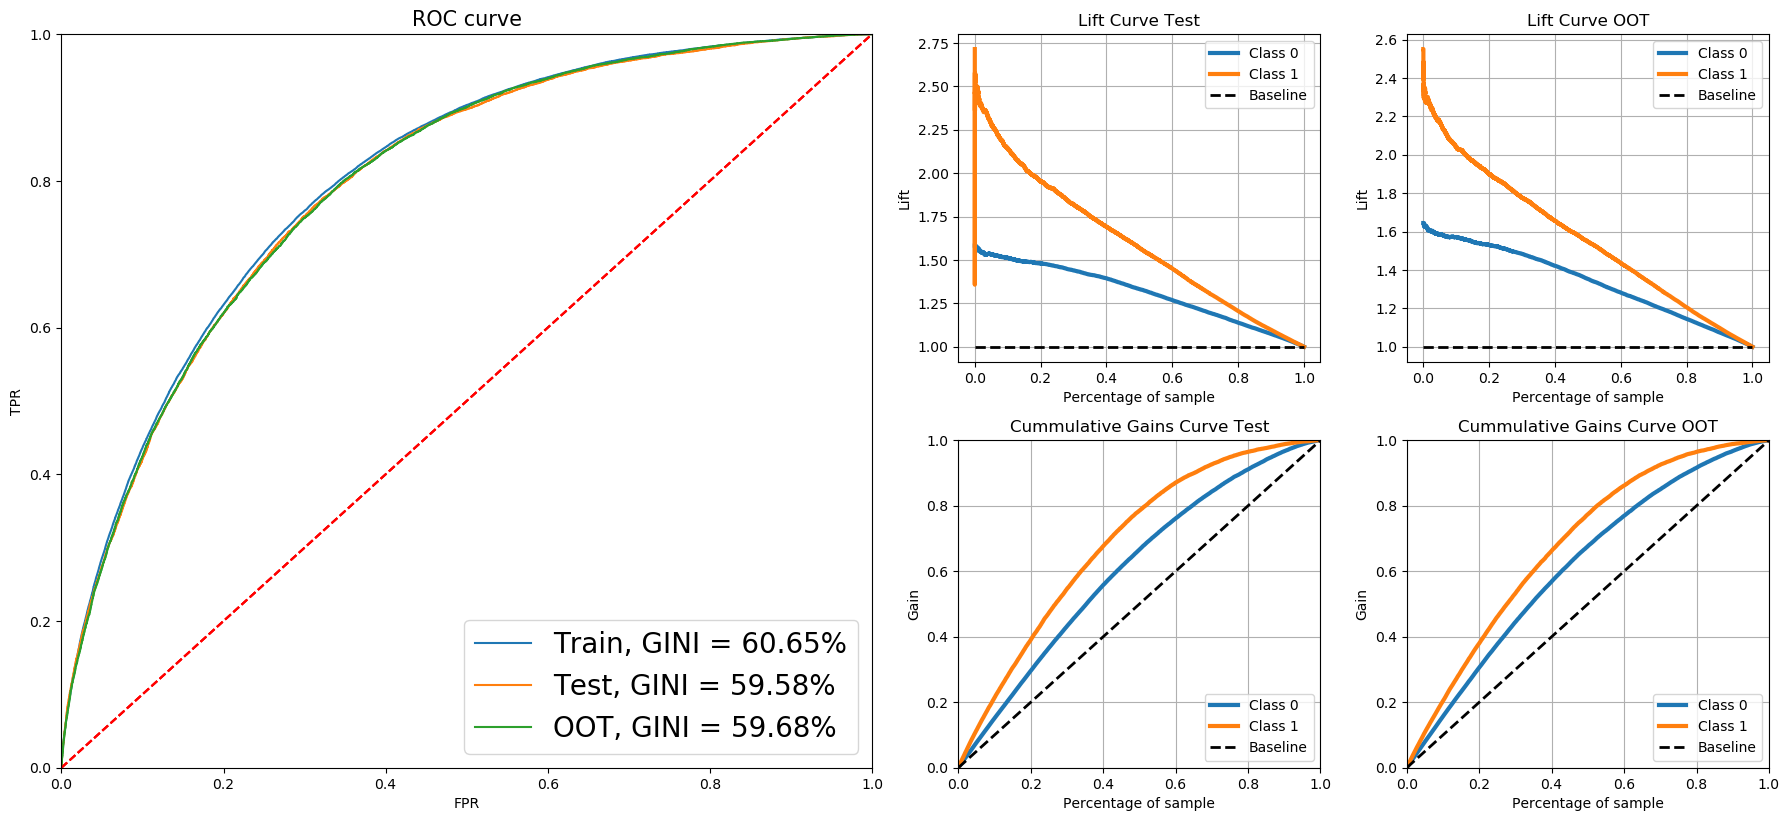

In [590]:
roc_lift_gain(model=model_logreg, 
              data = {'Train':[train_bin[survivors], y_train], 
                      'Test':[test_bin[survivors], y_test], 
                      'OOT':[oot_bin[survivors], y_oot]})

In [591]:
train_lgbm, test_lgbm, y_train, y_test = data_preprocessing(train[survivors],
                                                                      y_train,
                                                                      test[survivors],
                                                                      y_test,
                                                                      necessary_fields,
                                                                      categorial_list=categories_bin,
                                                                      yeo_johnson=False,
                                                                      attribute_list=None,
                                                                      var_col=None,
                                                                      scale=False,
                                                                      median='median',
                                                                      check_percentile=5,
                                                                      high_outlier=None,
                                                                      low_outlier=None,
                                                                      cols_outlier=[],
                                                                      cut_non_out_9999=False)

train_lgbm, oot_lgbm,  y_train, y_oot = data_preprocessing(train[survivors],
                                                                     y_train,
                                                                     oot[survivors],
                                                                     y_oot,
                                                                     necessary_fields,
                                                                     categorial_list=categories_bin,
                                                                     yeo_johnson=False,
                                                                     attribute_list=None,
                                                                     var_col=None,
                                                                     scale=False,
                                                                     median='median',
                                                                     check_percentile=5,
                                                                     high_outlier=None,
                                                                     low_outlier=None,
                                                                     cols_outlier=[],
                                                                     cut_non_out_9999=False)

lightgbm_class = LGBMClassifier(**params_lgbm, verbosity=-1)
from datetime import datetime
print('Training started...', datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S"))
# train
default_model_lgbm = lightgbm_class.fit(train_lgbm[survivors], y_train)
print('Training finished...', datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S"))

y_train_pred_lgbm = default_model_lgbm.predict_proba(train_lgbm[survivors])[:, 1]
y_test_pred_lgbm = default_model_lgbm.predict_proba(test_lgbm[survivors])[:, 1]
y_oot_pred_lgbm = default_model_lgbm.predict_proba(oot_lgbm[survivors])[:, 1]

lgbm_stats = model_stats(clf=default_model_lgbm, data_dict={'Train': [train_lgbm[survivors], y_train], 
                                                            'Test': [test_lgbm[survivors], y_test], 
                                                            'OOT': [oot_lgbm[survivors], y_oot]},
                        round_to = 5)

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Training started... 12.06.2022 18:58:16
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
Training finished... 12.06.2022 18:58:17
